# <span style="color:green"> Numerical Simulation Laboratory </span>
## <span style="color:brown"> Python Exercise 11 </span>
## <span style="color:orange"> Keras - Neural Network regression </span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adagrad, RMSprop, Nadam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

import matplotlib.style as style 
style.use('tableau-colorblind10')

mod_names = ["NODE MODEL","LAYER MODEL","NODE & LAYER MODEL"]
mod_label = ["Nod_mod", "Lay_mod", "Mix_mod"]
plt.rcParams.update({'font.size': 20})

2023-10-06 12:15:29.470201: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-06 12:15:29.506538: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-06 12:15:29.507170: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-06 12:15:30.063576: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


The goal of this exercises is to perform ML regression on noisy data usign a feedforward neural network (NN).

The universal approximation theorem guarantees that Neural Networks can transform (non linearly) the input $X$ into an output $Y$ that depends on the weights and biases of all the neurons in the network, whatever it is the form of the function that links $X$ to $Y$.

We will be using a [Sequential model](https://keras.io/guides/sequential_model/) to model the layers of our network.

We will takle the **prediction problem**: given a probabilistic process that outputs labeled data $(x,y)$, with $y_i = f(x_i)+\eta_i$, $\eta_i$ gaussian and uncorrelated noise such that: $\langle \eta_i \rangle=0$ and $\langle \eta_i \eta_j \rangle=\delta_{ij}\sigma$, the output of our neural network will provide us with a set of prediction $\{ y_j^{\text{pred}} \}$. To measure the goodness of our hypothesis we measure on the test set the sum of the mean square error (MSE).

$$
MSE= \frac{1}{N_\mathrm{test}}\sum_{j=1}^{N_\mathrm{test}} (y_j^\mathrm{pred}-y_j)^2
$$

# Exercise 11.1
### Linear regression

Our first steps should be easy ones, so in this exercise we have a dataset distributed following:

$$
f(x) = 2x +1.
$$

In this case a network of a single layer and a single neuron is enough to tackle the problem.

The only parameters to be optimized will be the weights $w_j$ and the biases $b_j$. At first the parameters we will use are: $N_{\text{train}}=300$ and $N_{\text{valid}}=30$ (our test values, in this case directly sampled from the analytical model). Our network will be trained using **30 epochs**, the noise is $\sigma=0$. We explore how changing this values will impact the predictive power of our model.

In the beginning, I want to explore a very simple linear fit where the data is arranged linearly without any uncertainty. So, we want to investigate the goodness of the fit while varying two parameters: the number of training values and the number of epochs. Subsequently, we can introduce Gaussian noise into the training and validation datasets.


As a first thing, we generate and plot a set of input data that will be used as training set and test set.

In [2]:
def generate_input(n_train,m,b,sigma):
    # generate training inputs
    n_valid = int(n_train/10)
    np.random.seed(0)
    x_train = np.random.uniform(-1, 1, n_train)
    x_valid = np.random.uniform(-1, 1, n_valid)
    x_valid.sort()
    y_target = m * x_valid + b # ideal (target) linear function

    y_train = np.random.normal(m * x_train + b, sigma) # actual measures from which we want to guess regression parameters
    y_valid = np.random.normal(m * x_valid + b, sigma)
    return x_train, x_valid, y_target ,y_train, y_valid

def Set_model(n_node):
    # compose the NN model
    model = tf.keras.Sequential()
    model.add(Dense(n_node, input_shape=(1,)))#let add just one layer and n_node node.

    # compile the model choosing optimizer, loss and metrics objects
    model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

    # get a summary of our composed model
    model.summary()
    
    # save the weights that we will use later
    model.save_weights('./Weights/model.h5')
    return model
    
def Test(n_epochs):
    #test my model
    history = model.fit(x=x_train, y=y_train, 
            batch_size=32, epochs=n_epochs,
            shuffle=True, # a good idea is to shuffle input before at each epoch
            validation_data=(x_valid, y_valid),
            verbose = 1)
    return history;

In [3]:
def plot_model(): 
    par = model.get_weights()

    #print('\n\n------------------------------------------------------\n')
    #print('The model function obtained is: \n\nf(x) = '+ str(float(par[0]))+'x + ' +str(float(par[1])))
    #print('\n\n------------------------------------------------------')

    # look into training history
    # Plot training & validation loss values
    plt. subplots(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'],linewidth =4)
    plt.plot(history.history['val_loss'],linewidth =4)
    plt.title('Model loss', fontsize=16)
    plt.grid()
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='best')

    # Plot target and fit
    plt.subplot(1,2,2)
    plt.title('Target function and predicted function', fontsize=16)
    x_predicted = np.random.uniform(-1, 1, 100)
    y_predicted = model.predict(x_predicted)
    # Fitted function
    plt.scatter(x_train, y_train,color = 'green', label='training')
    plt.scatter(x_predicted, y_predicted,s = 100,color = 'blue', label='predicted')
    # Target function
    plt.plot(x_valid, y_target,linewidth =4,color='red', label='target')
    plt.legend()
    plt.grid(True)
    plt.show()

def print_performance(model, y_target, x_valid, y_valid,bs):
    print('\n\n------------------------------------------------------\n')
    # evaluate model
    score = model.evaluate(x_valid, y_target, batch_size=bs, verbose=1)

    # print performance
    print()
    print('Evaluation of the model by comparison with the exact curve:')
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    print('\n\n------------------------------------------------------')
    return score[0], score[1]


### **TEST 1**:
We are now going to train our model, that is we feed the neuron with the set of training pair x, y_train from which the optimizer will find the best weights to minimize the Mean Square Error loss function (out linear regression function).

INFO Parameters:
- epochs = 30
- training data = 300
- without noise

In [4]:
#TEST 1
# target parameters of f(x) = m*x + b
m = 2 # slope
b = 1 # intersect
sigma = 0 # noise standard deviation, for the moment it is absent
n_train = 300
n_epochs = 30
n_node = 1
#generate input data
x_train, x_valid, y_target ,y_train, y_valid = generate_input(n_train,m,b,sigma)

#setting model
model = Set_model(n_node)

#load weights
model.load_weights('./Weights/model.h5')

#starting model
history = Test(n_epochs)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
10/10 [==============================] - 0s 14ms/step - loss: 1.4987 - mse: 1.4987 - val_loss: 0.7999 - val_mse: 0.7999
Epoch 2/30
10/10 [==============================] - 0s 3ms/step - loss: 1.1311 - mse: 1.1311 - val_loss: 0.6151 - val_mse: 0.6151
Epoch 3/30
10/10 [==============================] - 0s 3ms/step - loss: 0.8728 - mse: 0.8728 - val_loss: 0.4863 - val_mse: 0.4863
Epoch 4/30
10/10 [==============================] - 0s 3ms/step - loss: 0.6854 - mse: 0.6854 - val_loss: 0.3944 - val_mse: 0.3944
Epoch 5/30
10/10 [===============

4/4 [==============================] - 0s 1ms/step


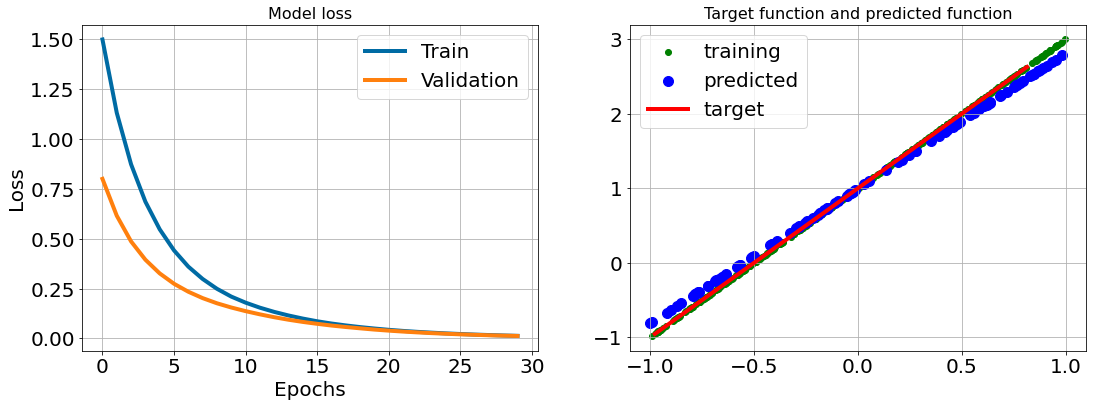



------------------------------------------------------

1/1 [==============================] - 0s 18ms/step - loss: 0.0121 - mse: 0.0121

Evaluation of the model by comparison with the exact curve:
Test loss: 0.012146937660872936
Test accuracy: 0.012146937660872936


------------------------------------------------------


(0.012146937660872936, 0.012146937660872936)

In [5]:
#plot
plot_model()
print_performance(model, y_target, x_valid, y_valid, 32)

**OBSERVATION**


First we ran the model with 300 trains, using 10% of trains are used to validate the test, and 30 epochs

On the right one observe that the fit has to be improved. Left plot show that to improve results is enough to increase the number of epochs.

### Test 2: **increase the number of epochs from 30 to 100**

INFO Parameters:
- epochs = 100
- training data = 300
- without noise

In [6]:
#TEST 2
n_train = 300
x_predicted = np.random.uniform(-1, 1, 100)
n_epochs = [30, 50, 80, 100]

loses=[]
val_loses=[]
y_predicted=[]
for n_epoch in n_epochs:

    #generate input data
    #x_train, x_valid, y_target ,y_train, y_valid = generate_input(n_train,m,b,sigma)

    #load weights
    model.load_weights('./Weights/model.h5')

    #starting model
    history = Test(n_epoch)
    
    loses.append(history.history['loss'])
    val_loses.append(history.history['val_loss'])
    

    y_predicted.append(model.predict(x_predicted))
    
    #print
    print_performance(model, y_target, x_valid, y_valid, 32)

Epoch 1/30
10/10 [==============================] - 0s 6ms/step - loss: 1.4984 - mse: 1.4984 - val_loss: 0.7943 - val_mse: 0.7943
Epoch 2/30
10/10 [==============================] - 0s 3ms/step - loss: 1.1229 - mse: 1.1229 - val_loss: 0.6065 - val_mse: 0.6065
Epoch 3/30
10/10 [==============================] - 0s 3ms/step - loss: 0.8599 - mse: 0.8599 - val_loss: 0.4764 - val_mse: 0.4764
Epoch 4/30
10/10 [==============================] - 0s 3ms/step - loss: 0.6703 - mse: 0.6703 - val_loss: 0.3856 - val_mse: 0.3856
Epoch 5/30
10/10 [==============================] - 0s 3ms/step - loss: 0.5328 - mse: 0.5328 - val_loss: 0.3183 - val_mse: 0.3183
Epoch 6/30
10/10 [==============================] - 0s 3ms/step - loss: 0.4283 - mse: 0.4283 - val_loss: 0.2692 - val_mse: 0.2692
Epoch 7/30
10/10 [==============================] - 0s 3ms/step - loss: 0.3509 - mse: 0.3509 - val_loss: 0.2312 - val_mse: 0.2312
Epoch 8/30
10/10 [==============================] - 0s 3ms/step - loss: 0.2913 - mse: 0.29

Epoch 31/50
10/10 [==============================] - 0s 3ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 32/50
10/10 [==============================] - 0s 3ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 33/50
10/10 [==============================] - 0s 3ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 34/50
10/10 [==============================] - 0s 3ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 35/50
10/10 [==============================] - 0s 3ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 36/50
10/10 [==============================] - 0s 3ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 37/50
10/10 [==============================] - 0s 3ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 38/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0042 - m

10/10 [==============================] - 0s 3ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 41/80
10/10 [==============================] - 0s 3ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 42/80
10/10 [==============================] - 0s 3ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 43/80
10/10 [==============================] - 0s 3ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 44/80
10/10 [==============================] - 0s 3ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 45/80
10/10 [==============================] - 0s 3ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 46/80
10/10 [==============================] - 0s 3ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 47/80
10/10 [==============================] - 0s 3ms/step - loss: 0.0013 - mse: 0.0013 -

Epoch 16/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0838 - mse: 0.0838 - val_loss: 0.0721 - val_mse: 0.0721
Epoch 17/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0725 - mse: 0.0725 - val_loss: 0.0636 - val_mse: 0.0636
Epoch 18/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0632 - mse: 0.0632 - val_loss: 0.0560 - val_mse: 0.0560
Epoch 19/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0549 - mse: 0.0549 - val_loss: 0.0492 - val_mse: 0.0492
Epoch 20/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0477 - mse: 0.0477 - val_loss: 0.0431 - val_mse: 0.0431
Epoch 21/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0414 - mse: 0.0414 - val_loss: 0.0377 - val_mse: 0.0377
Epoch 22/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 23/100
10/10 [==============================] - 0s 3ms/step - loss: 0.

Epoch 75/100
10/10 [==============================] - 0s 3ms/step - loss: 2.7956e-05 - mse: 2.7956e-05 - val_loss: 2.6569e-05 - val_mse: 2.6569e-05
Epoch 76/100
10/10 [==============================] - 0s 3ms/step - loss: 2.4396e-05 - mse: 2.4396e-05 - val_loss: 2.3345e-05 - val_mse: 2.3345e-05
Epoch 77/100
10/10 [==============================] - 0s 3ms/step - loss: 2.1374e-05 - mse: 2.1374e-05 - val_loss: 2.0400e-05 - val_mse: 2.0400e-05
Epoch 78/100
10/10 [==============================] - 0s 3ms/step - loss: 1.8665e-05 - mse: 1.8665e-05 - val_loss: 1.7853e-05 - val_mse: 1.7853e-05
Epoch 79/100
10/10 [==============================] - 0s 3ms/step - loss: 1.6334e-05 - mse: 1.6334e-05 - val_loss: 1.5657e-05 - val_mse: 1.5657e-05
Epoch 80/100
10/10 [==============================] - 0s 3ms/step - loss: 1.4293e-05 - mse: 1.4293e-05 - val_loss: 1.3762e-05 - val_mse: 1.3762e-05
Epoch 81/100
10/10 [==============================] - 0s 3ms/step - loss: 1.2505e-05 - mse: 1.2505e-05 - val_los

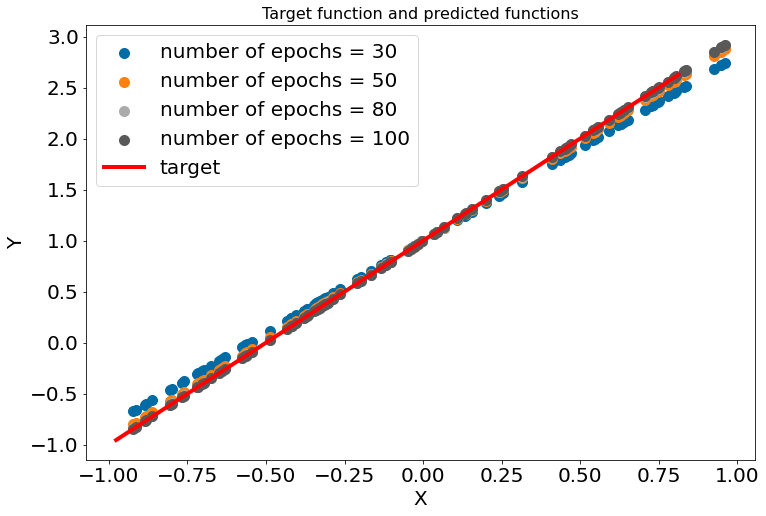

In [7]:
plt.figure(figsize=(12,8))
plt.title('Target function and predicted functions', fontsize=16)
count=0
for y_predict in y_predicted:
    # Fitted function
    plt.scatter(x_predicted, y_predict, s=100, label=f'number of epochs = {n_epochs[count]}')
    count=count+1
# Target function
plt.ylabel('Y')
plt.xlabel('X')
plt.plot(x_valid, y_target,linewidth=4,c="red", label='target')
plt.legend()

### OBSERVATION

We performed the test for increasing number of epochs. We observe that the time x steps is around 3ms/step and doesn't depend on the number of epochs. It means that the execution time encrease linearly with the number of epochs.



### Test 3: increase the training data from 30 to 700
We want check one can reduce the time x step, so we test the model by increasing the number of throws and leaving the number of epochs unchanged.

INFO Parameters:
- epochs = 30
- training data elements= 1000
- without noise

In [8]:
#TEST 3

n_trains = [30,100,200,500,700]
x_predicted = np.random.uniform(-1, 1, 100)
n_epochs = 30
n_node = 1

loses=[]
val_loses=[]
y_predicted=[]
for n_train in n_trains:
    
    #generate input data
    x_train, x_valid, y_target ,y_train, y_valid = generate_input(n_train,m,b,sigma)
    
    model = Set_model(n_node)
    
    #starting model
    history = Test(n_epochs)
    
    loses.append(history.history['loss'])
    val_loses.append(history.history['val_loss'])
    

    y_predicted.append(model.predict(x_predicted))
    
    #print
    print_performance(model, y_target, x_valid, y_valid, 32)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
1/1 [==============================] - 0s 250ms/step - loss: 5.1116 - mse: 5.1116 - val_loss: 2.5205 - val_mse: 2.5205
Epoch 2/30
1/1 [==============================] - 0s 21ms/step - loss: 4.9668 - mse: 4.9668 - val_loss: 2.4405 - val_mse: 2.4405
Epoch 3/30
1/1 [==============================] - 0s 20ms/step - loss: 4.8272 - mse: 4.8272 - val_loss: 2.3639 - val_mse: 2.3639
Epoch 4/30
1/1 [==============================] - 0s 21ms/step - loss: 4.6926 - mse: 4.6926 - val_loss: 2.2904 - val_mse: 2.2904
Epoch 5/30
1/1 [===================

4/4 [==============================] - 0s 7ms/step - loss: 0.4039 - mse: 0.4039 - val_loss: 0.4398 - val_mse: 0.4398
Epoch 23/30
4/4 [==============================] - 0s 7ms/step - loss: 0.3815 - mse: 0.3815 - val_loss: 0.4008 - val_mse: 0.4008
Epoch 24/30
4/4 [==============================] - 0s 7ms/step - loss: 0.3540 - mse: 0.3540 - val_loss: 0.3671 - val_mse: 0.3671
Epoch 25/30
4/4 [==============================] - 0s 7ms/step - loss: 0.3301 - mse: 0.3301 - val_loss: 0.3464 - val_mse: 0.3464
Epoch 26/30
4/4 [==============================] - 0s 7ms/step - loss: 0.3126 - mse: 0.3126 - val_loss: 0.3305 - val_mse: 0.3305
Epoch 27/30
4/4 [==============================] - 0s 7ms/step - loss: 0.2981 - mse: 0.2981 - val_loss: 0.3150 - val_mse: 0.3150
Epoch 28/30
4/4 [==============================] - 0s 6ms/step - loss: 0.2839 - mse: 0.2839 - val_loss: 0.2971 - val_mse: 0.2971
Epoch 29/30
4/4 [==============================] - 0s 7ms/step - loss: 0.2694 - mse: 0.2694 - val_loss: 0.283

Epoch 11/30
16/16 [==============================] - 0s 2ms/step - loss: 0.3650 - mse: 0.3650 - val_loss: 0.3004 - val_mse: 0.3004
Epoch 12/30
16/16 [==============================] - 0s 2ms/step - loss: 0.2934 - mse: 0.2934 - val_loss: 0.2419 - val_mse: 0.2419
Epoch 13/30
16/16 [==============================] - 0s 2ms/step - loss: 0.2359 - mse: 0.2359 - val_loss: 0.1947 - val_mse: 0.1947
Epoch 14/30
16/16 [==============================] - 0s 2ms/step - loss: 0.1898 - mse: 0.1898 - val_loss: 0.1565 - val_mse: 0.1565
Epoch 15/30
16/16 [==============================] - 0s 2ms/step - loss: 0.1523 - mse: 0.1523 - val_loss: 0.1260 - val_mse: 0.1260
Epoch 16/30
16/16 [==============================] - 0s 2ms/step - loss: 0.1225 - mse: 0.1225 - val_loss: 0.1014 - val_mse: 0.1014
Epoch 17/30
16/16 [==============================] - 0s 2ms/step - loss: 0.0986 - mse: 0.0986 - val_loss: 0.0815 - val_mse: 0.0815
Epoch 18/30
16/16 [==============================] - 0s 2ms/step - loss: 0.0792 - m

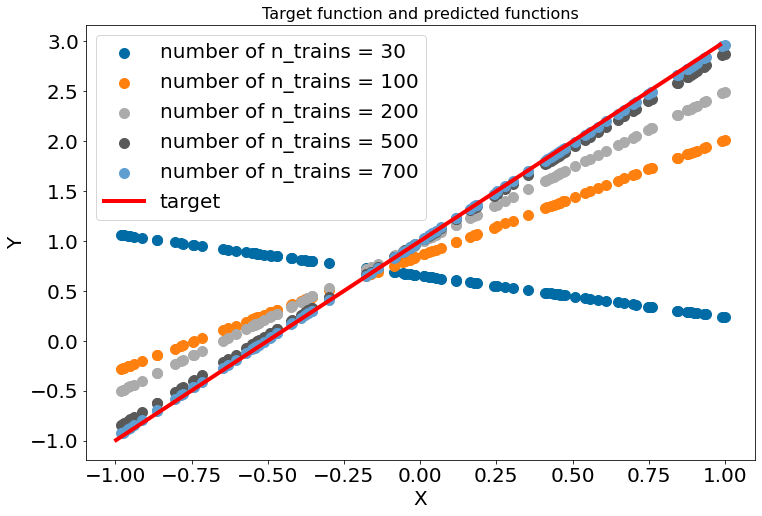

In [9]:
plt.figure(figsize=(12,8))
plt.title('Target function and predicted functions', fontsize=16)
count=0
for y_predict in y_predicted:
    # Fitted function
    plt.scatter(x_predicted, y_predict, s=100, label=f'number of n_trains = {n_trains[count]}')
    count=count+1
# Target function
plt.ylabel('Y')
plt.xlabel('X')
plt.plot(x_valid, y_target,linewidth=4,c="red", label='target')
plt.legend()

### OBSERVATION

**more training is better than more epochs**

The step time significantly decreases from 8ms/step when using 300 training iterations, reaching a plateau at around 1-2ms/step with over 800 training iterations. Good convergence is achieved already after 600 training iterations.

### TEST 4: Introducing a noise

We are going to test hte same model with the introduction of a sigma noise. 

MODEL PARAMETERs

- training data elements = 1000
- epochs = 30
- sigma noise = 0.5

In [10]:
#TEST 4
n_train = 1000
n_epochs = 30
sigma = 0.5
#generate input data
x_train, x_valid, y_target ,y_train, y_valid = generate_input(n_train,m,b,sigma)

model = Set_model(n_node)

#load weights
model.load_weights('./Weights/model.h5')

#starting model
history = Test(n_epochs)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
32/32 [==============================] - 0s 4ms/step - loss: 1.4771 - mse: 1.4771 - val_loss: 1.1445 - val_mse: 1.1445
Epoch 2/30
32/32 [==============================] - 0s 2ms/step - loss: 0.8244 - mse: 0.8244 - val_loss: 0.7394 - val_mse: 0.7394
Epoch 3/30
32/32 [==============================] - 0s 2ms/step - loss: 0.5610 - mse: 0.5610 - val_loss: 0.5410 - val_mse: 0.5410
Epoch 4/30
32/32 [==============================] - 0s 2ms/step - loss: 0.4317 - mse: 0.4317 - val_loss: 0.4278 - val_mse: 0.4278
Epoch 5/30
32/32 [==============

4/4 [==============================] - 0s 1ms/step


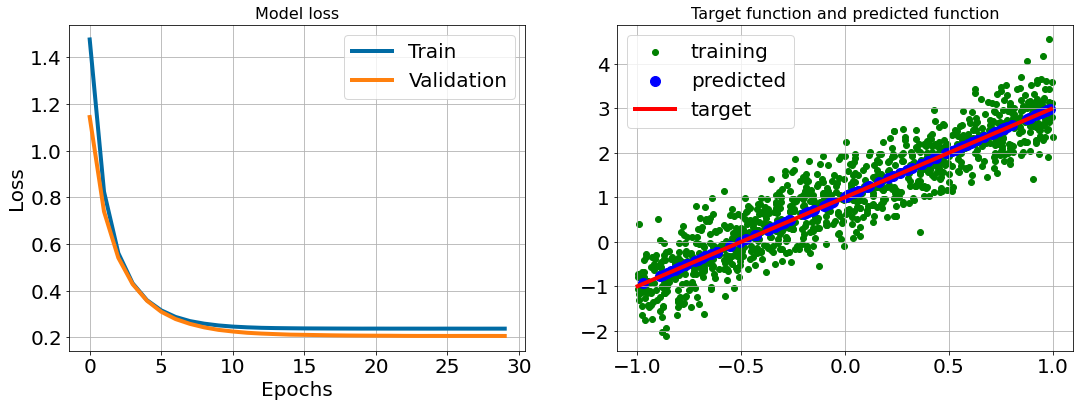



------------------------------------------------------

4/4 [==============================] - 0s 2ms/step - loss: 2.2753e-04 - mse: 2.2753e-04

Evaluation of the model by comparison with the exact curve:
Test loss: 0.0002275349252158776
Test accuracy: 0.0002275349252158776


------------------------------------------------------


(0.0002275349252158776, 0.0002275349252158776)

In [11]:
#plot
plot_model()
print_performance(model, y_target, x_valid, y_valid, 32)

Obviusly introducing a noise in dataset generator lead to worse results. In addiction one could observe the loss curve got a gap between validation and train values. This gap show us we are not overstiming the results.

### Exercise 11.2


To extend the model to obtain a reasonable fit for the given polynomial of order 3:

$$
f(x)=4-3x-2x^2+3x^3
$$
for $x \in [-1,1]$.

We need to make several choices for our neural network:

- Number of Layers: Experiment with different numbers of layers to find an optimal choice. Start with a few hidden layers and adjust as needed.

- Number of Neurons in Each Layer: The number of neurons in each layer is a hyperparameter that you should tune. Start with a moderate number and increase or decrease based on performance.

- Activation Function: You can try different activation functions like ReLU, sigmoid, or tanh and see which one works best for this problem.

- Optimizer: Choose an optimizer like SGD, Adam, or RMSprop to optimize your neural network. The choice of optimizer can affect training speed and convergence.

- Loss Function: For regression problems like this, mean squared error (MSE) is a common choice for the loss function. However, you can experiment with other loss functions depending on your specific requirements.

After training your neural network, evaluate its performance by:

- Checking how well it predicts newly generated test data, both within and outside the range of $x$ where you trained the model.

- Analyzing how well the model performs on points within the training data range compared to points outside the original training dataset.

In your summary, we will discuss the relationship between model complexity (number of parameters), the goodness of fit on the training data, and the ability to make accurate predictions. This analysis will help to understand the trade-offs between model complexity and generalization.

In [12]:
def polynomial(x):
    return 4-3*x-2*x*x+3*x*x*x

def generate_input(n_train):
    # generate training inputs
    n_valid = 100
    np.random.seed(0)
    x_train = np.random.uniform(-1, 1, n_train)
    x_valid = np.random.uniform(-1, 1, n_valid)
    x_valid.sort()
    
    y_target = polynomial(x_valid) # ideal (target) linear function
    y_valid = np.random.normal(polynomial(x_valid),sigma)

    y_train = np.random.normal(polynomial(x_train),sigma) # actual measures from which we want to guess regression parameters

    return x_train, x_valid, y_target ,y_train, y_valid

#define models
def Set_models(n_layer, n_node,activationN,activationL,activationM):
    
    print("GENERATING MODELS:\n")
    # compose the model with more nodes
    Nod_mod = tf.keras.Sequential()
    Nod_mod.add(Dense(1, input_shape=(1,),activation=activationN))
    Nod_mod.add(Dense(n_node, input_shape=(1,),activation=activationN))
    Nod_mod.add(Dense(1, input_shape=(1,),activation=activationN))
    
    # compose the model with more layer
    Lay_mod = tf.keras.Sequential()
    for i in range(n_layer): Lay_mod.add(Dense(1, input_shape=(1,),activation=activationL))

    # compose the model with more layer & more nodes
    Mix_mod = tf.keras.Sequential()
    Mix_mod.add(Dense(1, input_shape=(1,),activation=activationM))
    for i in range(3): Mix_mod.add(Dense(3-1+i, input_shape=(1,),activation=activationM))
    for i in range(3): Mix_mod.add(Dense(3-i, input_shape=(1,),activation=activationM))
    Mix_mod.add(Dense(1, input_shape=(1,),activation=activationM))

    return [Nod_mod, Lay_mod, Mix_mod]
#model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
def Compile(models, opts,loss,met,mod_names):
    i=0
    #mod_label = ["Nod_mod", "Lay_mod", "Mix_mod"]
    for model in models:
        print("Compiling model ",mod_label[i])
        model.compile(optimizer=opts[i], loss=loss, metrics=[met])
        #model.save_weights(f'Weights/{mod_label[i]}.h5')
        model.summary(); print()
        i=i+1
        
    
def History(models,n_epochs,mod_names): #training model with history database
    #load weights
    j=0
    history = []
    for model in models: 
        #model.load_weights(f'Weights/{mod_label[j]}.h5')
        history.append(model.fit(x = x_train, y = y_train, 
          batch_size=bs, epochs=n_epochs, shuffle=True,
          validation_data=(x_valid, y_valid), verbose=1))
        j=j+1
    return history

Here, we are investigating three types of models:

- **Nod Model**: The first model consists of 3 layers, with the hidden layer having 15 nodes, while the side layers have only one node each.

- **Lay Model**: A model composed of 15 layers, each with a single node.

- **Mix Model**: The third model contains a mixed number of layers and nodes, such that the number of nodes on the sides increases in a pyramid-like fashion as we move towards the center.

In [13]:
n_train = 10000
n_epochs = 30
n_layer = 10
n_node = 15
sigma = 0.2
bs = 150 #banchsize

y_predicted= [[],[],[]]

x_predicted = np.random.uniform(-1, 1, 100)

In [14]:
#generate input data
x_train, x_valid, y_target ,y_train, y_valid = generate_input(n_train)

#setting model
models = Set_models(n_layer, n_node, "elu", "elu", "elu")

#compiling
Compile(models, ['sgd','sgd','sgd'],'mse','mse',mod_names)#SGD o Adam

#starting model
histo = History(models,n_epochs,mod_names)

#y_predicted[0].append(models[0].predict(x_predicted))
#y_predicted[1].append(models[1].predict(x_predicted))
#y_predicted[2].append(models[2].predict(x_predicted))

GENERATING MODELS:

Compiling model  Nod_mod
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 1)                 2         
                                                                 
 dense_8 (Dense)             (None, 15)                30        
                                                                 
 dense_9 (Dense)             (None, 1)                 16        
                                                                 
Total params: 48 (192.00 Byte)
Trainable params: 48 (192.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Compiling model  Lay_mod
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 1)                 2 

67/67 [==============================] - 1s 5ms/step - loss: 1.2828 - mse: 1.2828 - val_loss: 1.2254 - val_mse: 1.2254
Epoch 2/30
67/67 [==============================] - 0s 2ms/step - loss: 0.9410 - mse: 0.9410 - val_loss: 0.8743 - val_mse: 0.8743
Epoch 3/30
67/67 [==============================] - 0s 2ms/step - loss: 0.4729 - mse: 0.4729 - val_loss: 0.4792 - val_mse: 0.4792
Epoch 4/30
67/67 [==============================] - 0s 2ms/step - loss: 0.3620 - mse: 0.3620 - val_loss: 0.4448 - val_mse: 0.4448
Epoch 5/30
67/67 [==============================] - 0s 2ms/step - loss: 0.3447 - mse: 0.3447 - val_loss: 0.4307 - val_mse: 0.4307
Epoch 6/30
67/67 [==============================] - 0s 2ms/step - loss: 0.3346 - mse: 0.3346 - val_loss: 0.4216 - val_mse: 0.4216
Epoch 7/30
67/67 [==============================] - 0s 2ms/step - loss: 0.3274 - mse: 0.3274 - val_loss: 0.4147 - val_mse: 0.4147
Epoch 8/30
67/67 [==============================] - 0s 2ms/step - loss: 0.3218 - mse: 0.3218 - val_lo

NODE MODEL


------------------------------------------------------

1/1 [==============================] - 0s 19ms/step - loss: 0.2949 - mse: 0.2949

Evaluation of the model by comparison with the exact curve:
Test loss: 0.2949444353580475
Test accuracy: 0.2949444353580475


------------------------------------------------------
4/4 [==============================] - 0s 2ms/step


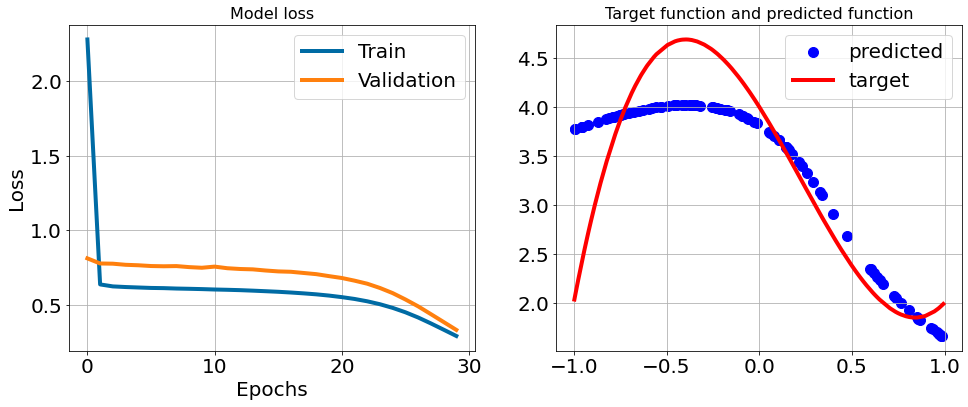

LAYER MODEL


------------------------------------------------------

1/1 [==============================] - 0s 19ms/step - loss: 0.3485 - mse: 0.3485

Evaluation of the model by comparison with the exact curve:
Test loss: 0.34845301508903503
Test accuracy: 0.34845301508903503


------------------------------------------------------
4/4 [==============================] - 0s 2ms/step


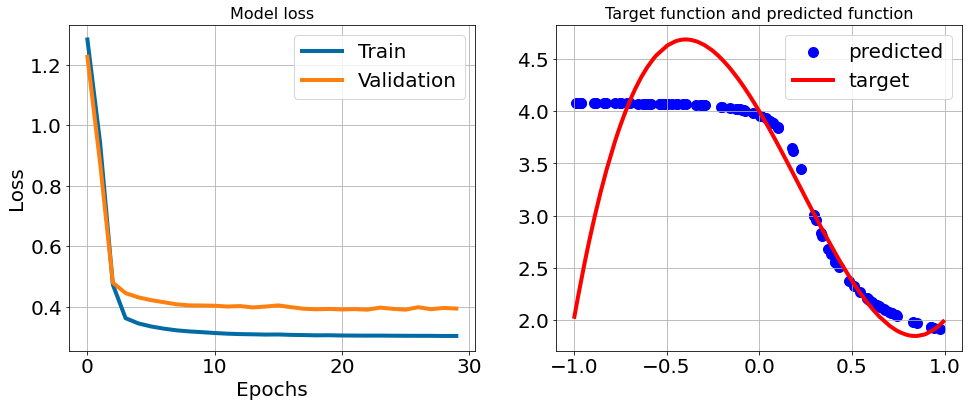

NODE & LAYER MODEL


------------------------------------------------------

1/1 [==============================] - 0s 21ms/step - loss: 0.3642 - mse: 0.3642

Evaluation of the model by comparison with the exact curve:
Test loss: 0.3641780912876129
Test accuracy: 0.3641780912876129


------------------------------------------------------
4/4 [==============================] - 0s 2ms/step


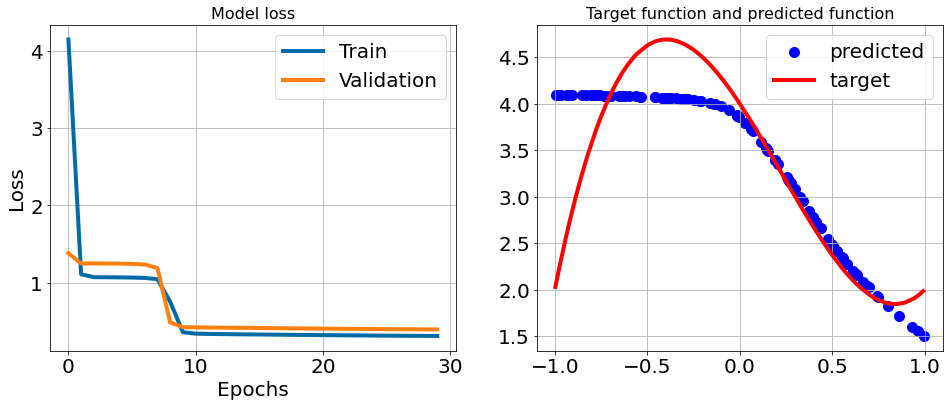

In [15]:
for i in range(len(models)):
    print(f'{mod_names[i]}')
    print_performance(models[i], y_target, x_valid, y_valid,150)

    # look into training history
    # Plot training & validation loss values
    plt. subplots(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(histo[i].history['loss'],linewidth=4)
    plt.plot(histo[i].history['val_loss'],linewidth=4)
    plt.title('Model loss', fontsize=16)
    plt.grid()
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='best')

    # Plot target and fit
    plt.subplot(1,2,2)
    plt.title('Target function and predicted function', fontsize=16)
    x_predicted = np.random.uniform(-1, 1, 100)
    y_predicted = models[i].predict(x_predicted)
    # Fitted function
    #plt.plot(x_predicted, y_predicted,'ro', label='predicted')

    #plt.scatter(x_train, y_train,s = 100,color = 'green', label='training')
    plt.scatter(x_predicted, y_predicted,s = 100,color = 'blue', label='predicted')
    # Target function
    plt.plot(x_valid, y_target,linewidth=4,color='red', label='target')
    plt.legend()
    plt.grid(True)
    plt.show()

**It appears that the better-performing models are those that involve a large number of nodes** rather than many layers. Despite the fact that the number of parameters for the Lay Model is lower compared to the other two models (two parameters for each node), this does not significantly alter the fit results.

### Investigate fit performance varying activation functions
Now try varying some activations functions to see which one is the most optimizing

In [16]:
activations =["elu","selu","relu","gelu"]#,"sigmoid","softmax","linear"]

In [17]:
multimodels=[]
y_predicted= [[],[],[]]
count=0
for activation in activations:
    print(activation," ACTIVATION FUNCTION")
    #setting model
    multimodels.append(Set_models(n_layer, n_node, activation,activation,activation))
    
    #compiling
    Compile(multimodels[count], ['sgd','sgd','sgd'],'mse','mse',mod_names)
    
    print("History")
    #starting model
    History(multimodels[count],n_epochs,mod_names)

    y_predicted[0].append(multimodels[count][0].predict(x_predicted))
    y_predicted[1].append(multimodels[count][1].predict(x_predicted))
    y_predicted[2].append(multimodels[count][2].predict(x_predicted))
    count=count+1


elu  ACTIVATION FUNCTION
GENERATING MODELS:

Compiling model  Nod_mod
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 1)                 2         
                                                                 
 dense_29 (Dense)            (None, 15)                30        
                                                                 
 dense_30 (Dense)            (None, 1)                 16        
                                                                 
Total params: 48 (192.00 Byte)
Trainable params: 48 (192.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Compiling model  Lay_mod
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (

67/67 [==============================] - 1s 4ms/step - loss: 2.1226 - mse: 2.1226 - val_loss: 1.2523 - val_mse: 1.2523
Epoch 2/30
67/67 [==============================] - 0s 2ms/step - loss: 1.0735 - mse: 1.0735 - val_loss: 1.2444 - val_mse: 1.2444
Epoch 3/30
67/67 [==============================] - 0s 2ms/step - loss: 1.0665 - mse: 1.0665 - val_loss: 1.2425 - val_mse: 1.2425
Epoch 4/30
67/67 [==============================] - 0s 2ms/step - loss: 1.0616 - mse: 1.0616 - val_loss: 1.2365 - val_mse: 1.2365
Epoch 5/30
67/67 [==============================] - 0s 2ms/step - loss: 1.0516 - mse: 1.0516 - val_loss: 1.2162 - val_mse: 1.2162
Epoch 6/30
67/67 [==============================] - 0s 2ms/step - loss: 1.0098 - mse: 1.0098 - val_loss: 1.0706 - val_mse: 1.0706
Epoch 7/30
67/67 [==============================] - 0s 2ms/step - loss: 0.5299 - mse: 0.5299 - val_loss: 0.4311 - val_mse: 0.4311
Epoch 8/30
67/67 [==============================] - 0s 2ms/step - loss: 0.3332 - mse: 0.3332 - val_lo

 dense_49 (Dense)            (None, 1)                 2         
                                                                 
 dense_50 (Dense)            (None, 15)                30        
                                                                 
 dense_51 (Dense)            (None, 1)                 16        
                                                                 
Total params: 48 (192.00 Byte)
Trainable params: 48 (192.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Compiling model  Lay_mod
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 1)                 2         
                                                                 
 dense_53 (Dense)            (None, 1)                 2         
                                                         

Epoch 3/30
67/67 [==============================] - 0s 2ms/step - loss: 1.0784 - mse: 1.0784 - val_loss: 1.2532 - val_mse: 1.2532
Epoch 4/30
67/67 [==============================] - 0s 2ms/step - loss: 1.0763 - mse: 1.0763 - val_loss: 1.2518 - val_mse: 1.2518
Epoch 5/30
67/67 [==============================] - 0s 2ms/step - loss: 1.0655 - mse: 1.0655 - val_loss: 1.2255 - val_mse: 1.2255
Epoch 6/30
67/67 [==============================] - 0s 2ms/step - loss: 1.0259 - mse: 1.0259 - val_loss: 1.1375 - val_mse: 1.1375
Epoch 7/30
67/67 [==============================] - 0s 2ms/step - loss: 0.7220 - mse: 0.7220 - val_loss: 0.5206 - val_mse: 0.5206
Epoch 8/30
67/67 [==============================] - 0s 2ms/step - loss: 0.3847 - mse: 0.3847 - val_loss: 0.4877 - val_mse: 0.4877
Epoch 9/30
67/67 [==============================] - 0s 2ms/step - loss: 0.3796 - mse: 0.3796 - val_loss: 0.4735 - val_mse: 0.4735
Epoch 10/30
67/67 [==============================] - 0s 2ms/step - loss: 0.3723 - mse: 0.3

                                                                 
 dense_72 (Dense)            (None, 1)                 16        
                                                                 
Total params: 48 (192.00 Byte)
Trainable params: 48 (192.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Compiling model  Lay_mod
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_73 (Dense)            (None, 1)                 2         
                                                                 
 dense_74 (Dense)            (None, 1)                 2         
                                                                 
 dense_75 (Dense)            (None, 1)                 2         
                                                                 
 dense_76 (Dense)            (None, 1)                 2 

Epoch 4/30
67/67 [==============================] - 0s 2ms/step - loss: 12.2059 - mse: 12.2059 - val_loss: 11.9946 - val_mse: 11.9946
Epoch 5/30
67/67 [==============================] - 0s 2ms/step - loss: 12.2059 - mse: 12.2059 - val_loss: 11.9946 - val_mse: 11.9946
Epoch 6/30
67/67 [==============================] - 0s 2ms/step - loss: 12.2059 - mse: 12.2059 - val_loss: 11.9946 - val_mse: 11.9946
Epoch 7/30
67/67 [==============================] - 0s 2ms/step - loss: 12.2059 - mse: 12.2059 - val_loss: 11.9946 - val_mse: 11.9946
Epoch 8/30
67/67 [==============================] - 0s 2ms/step - loss: 12.2059 - mse: 12.2059 - val_loss: 11.9946 - val_mse: 11.9946
Epoch 9/30
67/67 [==============================] - 0s 2ms/step - loss: 12.2059 - mse: 12.2059 - val_loss: 11.9946 - val_mse: 11.9946
Epoch 10/30
67/67 [==============================] - 0s 2ms/step - loss: 12.2059 - mse: 12.2059 - val_loss: 11.9946 - val_mse: 11.9946
Epoch 11/30
67/67 [==============================] - 0s 2ms/s

 dense_92 (Dense)            (None, 15)                30        
                                                                 
 dense_93 (Dense)            (None, 1)                 16        
                                                                 
Total params: 48 (192.00 Byte)
Trainable params: 48 (192.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Compiling model  Lay_mod
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_94 (Dense)            (None, 1)                 2         
                                                                 
 dense_95 (Dense)            (None, 1)                 2         
                                                                 
 dense_96 (Dense)            (None, 1)                 2         
                                                         

67/67 [==============================] - 0s 2ms/step - loss: 1.0787 - mse: 1.0787 - val_loss: 1.2573 - val_mse: 1.2573
Epoch 5/30
67/67 [==============================] - 0s 2ms/step - loss: 1.0783 - mse: 1.0783 - val_loss: 1.2574 - val_mse: 1.2574
Epoch 6/30
67/67 [==============================] - 0s 2ms/step - loss: 1.0782 - mse: 1.0782 - val_loss: 1.2578 - val_mse: 1.2578
Epoch 7/30
67/67 [==============================] - 0s 3ms/step - loss: 1.0782 - mse: 1.0782 - val_loss: 1.2573 - val_mse: 1.2573
Epoch 8/30
67/67 [==============================] - 0s 2ms/step - loss: 1.0783 - mse: 1.0783 - val_loss: 1.2576 - val_mse: 1.2576
Epoch 9/30
67/67 [==============================] - 0s 3ms/step - loss: 1.0782 - mse: 1.0782 - val_loss: 1.2581 - val_mse: 1.2581
Epoch 10/30
67/67 [==============================] - 0s 3ms/step - loss: 1.0782 - mse: 1.0782 - val_loss: 1.2579 - val_mse: 1.2579
Epoch 11/30
67/67 [==============================] - 0s 2ms/step - loss: 1.0782 - mse: 1.0782 - val_

In [18]:
i=0
j=0

minLossN = 100;
minLossL = 100;
minLossM = 100;
minAccN = 100;
minAccL = 100;
minAccM = 100;
bestActivFuncN = ""
bestActivFuncL = ""
bestActivFuncM = ""
for models in multimodels:
    print(activations[i])
    for model in models:
        #print(f'{mod_names[j]}')

        score = model.evaluate(x_valid, y_target, batch_size=bs, verbose=0)
        loss = score[0]
        accuracy = score[1]
        print( mod_names[j],"; loss = ",round(loss,4),"; accuracy = ",round(accuracy,4))
        
       
        if j == 0 and minLossN>loss:
            minLossN = loss
            minAccN = accuracy
            bestActivFuncN = activations[i]
        elif j == 1 and minLossL>loss:
            minLossL = loss
            minAccL = accuracy
            bestActivFuncL = activations[i]
        elif j == 2 and minLossM>loss:
            minLossM = loss
            minAccM = accuracy
            bestActivFuncM = activations[i]
        
        j=j+1
    print("__________")
    j=0
    i=i+1
print("The lowest loss value is given by:")
print( bestActivFuncN," activation function:", mod_names[0],"; loss = ",round(minLossN,4),"; accuracy = ",round(minAccN,4))
print( bestActivFuncL," activation function:", mod_names[1],"; loss = ",round(minLossL,4),"; accuracy = ",round(minAccL,4))
print( bestActivFuncM," activation function:", mod_names[2],"; loss = ",round(minLossM,4),"; accuracy = ",round(minAccM,4))

elu
NODE MODEL ; loss =  0.0335 ; accuracy =  0.0335
LAYER MODEL ; loss =  0.3505 ; accuracy =  0.3505
NODE & LAYER MODEL ; loss =  0.348 ; accuracy =  0.348
__________
selu
NODE MODEL ; loss =  0.0875 ; accuracy =  0.0875
LAYER MODEL ; loss =  0.4061 ; accuracy =  0.4061
NODE & LAYER MODEL ; loss =  0.02 ; accuracy =  0.02
__________
relu
NODE MODEL ; loss =  12.0706 ; accuracy =  12.0706
LAYER MODEL ; loss =  12.0706 ; accuracy =  12.0706
NODE & LAYER MODEL ; loss =  12.0706 ; accuracy =  12.0706
__________
gelu
NODE MODEL ; loss =  0.032 ; accuracy =  0.032
LAYER MODEL ; loss =  1.197 ; accuracy =  1.197
NODE & LAYER MODEL ; loss =  1.1946 ; accuracy =  1.1946
__________
The lowest loss value is given by:
gelu  activation function: NODE MODEL ; loss =  0.032 ; accuracy =  0.032
elu  activation function: LAYER MODEL ; loss =  0.3505 ; accuracy =  0.3505
selu  activation function: NODE & LAYER MODEL ; loss =  0.02 ; accuracy =  0.02


In [19]:
#generate input data
x_train, x_valid, y_target ,y_train, y_valid = generate_input(n_train)

#setting model
models = Set_models(n_layer, n_node,bestActivFuncN,'elu',bestActivFuncM)

#compiling
Compile(models, ['sgd','sgd','sgd'],'mse','mse',mod_names)#SGD o Adam

#starting model
histo = History(models,n_epochs,mod_names)

#y_predicted[0].append(models[0].predict(x_predicted))
#y_predicted[1].append(models[1].predict(x_predicted))
#y_predicted[2].append(models[2].predict(x_predicted))

GENERATING MODELS:

Compiling model  Nod_mod
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_112 (Dense)           (None, 1)                 2         
                                                                 
 dense_113 (Dense)           (None, 15)                30        
                                                                 
 dense_114 (Dense)           (None, 1)                 16        
                                                                 
Total params: 48 (192.00 Byte)
Trainable params: 48 (192.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Compiling model  Lay_mod
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_115 (Dense)           (None, 1)                 

67/67 [==============================] - 1s 5ms/step - loss: 2.0315 - mse: 2.0315 - val_loss: 1.2628 - val_mse: 1.2628
Epoch 2/30
67/67 [==============================] - 0s 2ms/step - loss: 1.0809 - mse: 1.0809 - val_loss: 1.2613 - val_mse: 1.2613
Epoch 3/30
67/67 [==============================] - 0s 3ms/step - loss: 1.0800 - mse: 1.0800 - val_loss: 1.2603 - val_mse: 1.2603
Epoch 4/30
67/67 [==============================] - 0s 3ms/step - loss: 1.0793 - mse: 1.0793 - val_loss: 1.2572 - val_mse: 1.2572
Epoch 5/30
67/67 [==============================] - 0s 3ms/step - loss: 1.0792 - mse: 1.0792 - val_loss: 1.2584 - val_mse: 1.2584
Epoch 6/30
67/67 [==============================] - 0s 3ms/step - loss: 1.0787 - mse: 1.0787 - val_loss: 1.2587 - val_mse: 1.2587
Epoch 7/30
67/67 [==============================] - 0s 3ms/step - loss: 1.0787 - mse: 1.0787 - val_loss: 1.2555 - val_mse: 1.2555
Epoch 8/30
67/67 [==============================] - 0s 2ms/step - loss: 1.0781 - mse: 1.0781 - val_lo

NODE MODEL


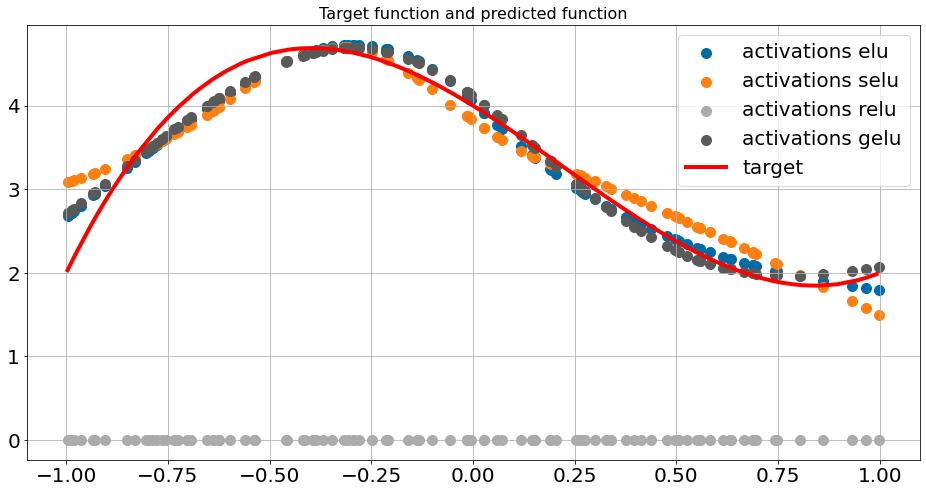

LAYER MODEL


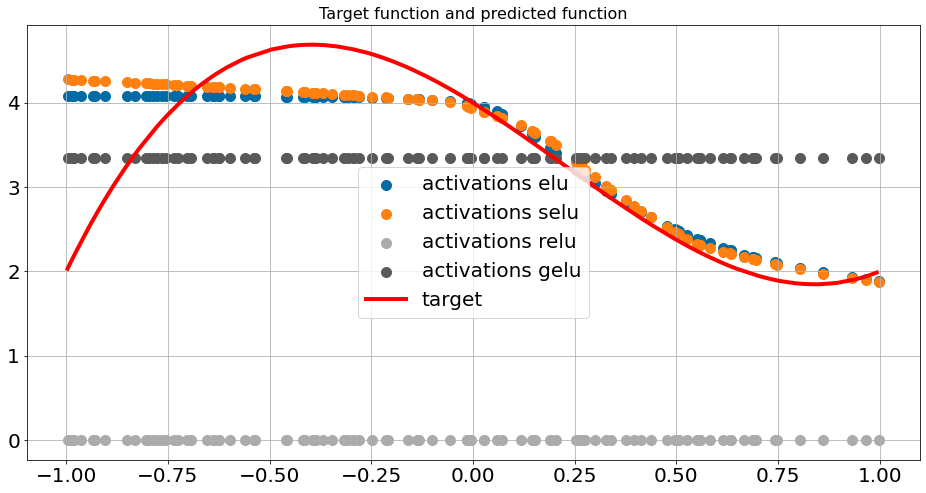

NODE & LAYER MODEL


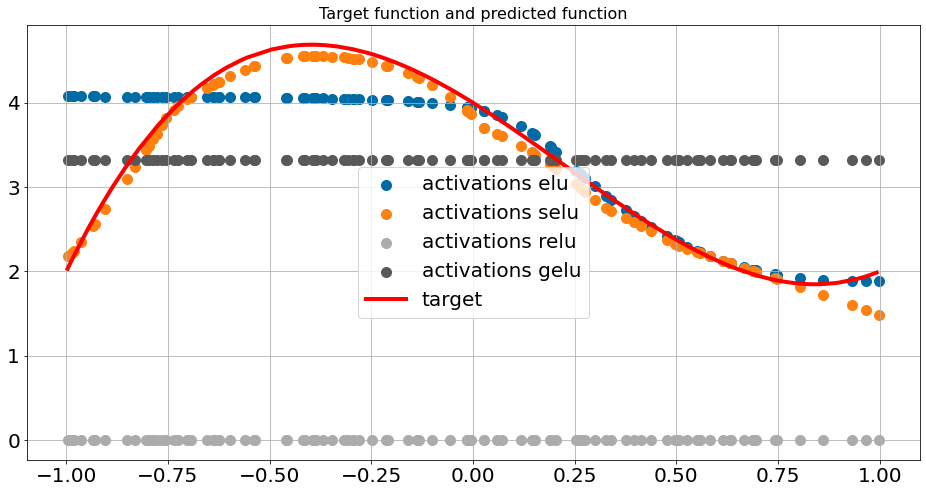

In [20]:

model_count = 0
for y_predict_model in y_predicted:#in the models array
    opt_count = 0
    plt.figure(figsize=(16,8))
    print(f'{mod_names[model_count]}')
    for y_predict_model_optimized in y_predict_model: #the y_predict with optimized parameters
        opt_count = opt_count+1
        plt.title('Target function and predicted function', fontsize=16)
        plt.scatter(x_predicted, y_predict_model_optimized,s = 100, label=f'activations {activations[opt_count-1]}')

    plt.plot(x_valid, y_target,linewidth=4,color='red', label='target')
    plt.legend()
    plt.grid(True)
    plt.show()
    model_count = model_count +1

### Investigate fit performance varying the optimizer

In [21]:
optimizer = ('sgd','RMSprop','Adadelta','Nadam','Adagrad')

In [22]:
multimodels=[]
multihistory=[]
y_predicted= [[],[],[]]
count=0

for optimization in optimizer:
    print(optimization," optimization method.")
    
    multimodels.append(Set_models(n_layer, n_node, bestActivFuncN,bestActivFuncL,bestActivFuncM))
    
    #compiling
    Compile(multimodels[count], [optimization,optimization,optimization],'mse','mse',mod_names)
    
    print("History")
    #starting model
    multihistory.append(History(multimodels[count],n_epochs,mod_names))
    
    y_predicted[0].append(multimodels[count][0].predict(x_predicted))
    y_predicted[1].append(multimodels[count][1].predict(x_predicted))
    y_predicted[2].append(multimodels[count][2].predict(x_predicted))
    
    count=count+1


sgd  optimization method.
GENERATING MODELS:

Compiling model  Nod_mod
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_133 (Dense)           (None, 1)                 2         
                                                                 
 dense_134 (Dense)           (None, 15)                30        
                                                                 
 dense_135 (Dense)           (None, 1)                 16        
                                                                 
Total params: 48 (192.00 Byte)
Trainable params: 48 (192.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Compiling model  Lay_mod
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_136 (Dense)           

67/67 [==============================] - 1s 5ms/step - loss: 2.4196 - mse: 2.4196 - val_loss: 1.1779 - val_mse: 1.1779
Epoch 2/30
67/67 [==============================] - 0s 2ms/step - loss: 0.8374 - mse: 0.8374 - val_loss: 0.6521 - val_mse: 0.6521
Epoch 3/30
67/67 [==============================] - 0s 2ms/step - loss: 0.4035 - mse: 0.4035 - val_loss: 0.4558 - val_mse: 0.4558
Epoch 4/30
67/67 [==============================] - 0s 3ms/step - loss: 0.3531 - mse: 0.3531 - val_loss: 0.4432 - val_mse: 0.4432
Epoch 5/30
67/67 [==============================] - 0s 2ms/step - loss: 0.3446 - mse: 0.3446 - val_loss: 0.4336 - val_mse: 0.4336
Epoch 6/30
67/67 [==============================] - 0s 2ms/step - loss: 0.3380 - mse: 0.3380 - val_loss: 0.4409 - val_mse: 0.4409
Epoch 7/30
67/67 [==============================] - 0s 3ms/step - loss: 0.3336 - mse: 0.3336 - val_loss: 0.4213 - val_mse: 0.4213
Epoch 8/30
67/67 [==============================] - 0s 3ms/step - loss: 0.3291 - mse: 0.3291 - val_lo

 dense_154 (Dense)           (None, 1)                 2         
                                                                 
 dense_155 (Dense)           (None, 15)                30        
                                                                 
 dense_156 (Dense)           (None, 1)                 16        
                                                                 
Total params: 48 (192.00 Byte)
Trainable params: 48 (192.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Compiling model  Lay_mod
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_157 (Dense)           (None, 1)                 2         
                                                                 
 dense_158 (Dense)           (None, 1)                 2         
                                                         

Epoch 3/30
67/67 [==============================] - 0s 3ms/step - loss: 9.7864 - mse: 9.7864 - val_loss: 8.9644 - val_mse: 8.9644
Epoch 4/30
67/67 [==============================] - 0s 3ms/step - loss: 8.4253 - mse: 8.4253 - val_loss: 7.5663 - val_mse: 7.5663
Epoch 5/30
67/67 [==============================] - 0s 3ms/step - loss: 6.9600 - mse: 6.9600 - val_loss: 6.1172 - val_mse: 6.1172
Epoch 6/30
67/67 [==============================] - 1s 14ms/step - loss: 5.4829 - mse: 5.4829 - val_loss: 4.6991 - val_mse: 4.6991
Epoch 7/30
67/67 [==============================] - 0s 3ms/step - loss: 4.0739 - mse: 4.0739 - val_loss: 3.4016 - val_mse: 3.4016
Epoch 8/30
67/67 [==============================] - 0s 3ms/step - loss: 2.8220 - mse: 2.8220 - val_loss: 2.3229 - val_mse: 2.3229
Epoch 9/30
67/67 [==============================] - 0s 3ms/step - loss: 1.8383 - mse: 1.8383 - val_loss: 1.5676 - val_mse: 1.5676
Epoch 10/30
67/67 [==============================] - 0s 3ms/step - loss: 1.2370 - mse: 1.

                                                                 
 dense_177 (Dense)           (None, 1)                 16        
                                                                 
Total params: 48 (192.00 Byte)
Trainable params: 48 (192.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Compiling model  Lay_mod
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_178 (Dense)           (None, 1)                 2         
                                                                 
 dense_179 (Dense)           (None, 1)                 2         
                                                                 
 dense_180 (Dense)           (None, 1)                 2         
                                                                 
 dense_181 (Dense)           (None, 1)                 2 

Epoch 4/30
67/67 [==============================] - 0s 3ms/step - loss: 12.1514 - mse: 12.1514 - val_loss: 11.9334 - val_mse: 11.9334
Epoch 5/30
67/67 [==============================] - 0s 3ms/step - loss: 12.1468 - mse: 12.1468 - val_loss: 11.9288 - val_mse: 11.9288
Epoch 6/30
67/67 [==============================] - 0s 3ms/step - loss: 12.1421 - mse: 12.1421 - val_loss: 11.9240 - val_mse: 11.9240
Epoch 7/30
67/67 [==============================] - 0s 3ms/step - loss: 12.1371 - mse: 12.1371 - val_loss: 11.9190 - val_mse: 11.9190
Epoch 8/30
67/67 [==============================] - 0s 3ms/step - loss: 12.1320 - mse: 12.1320 - val_loss: 11.9139 - val_mse: 11.9139
Epoch 9/30
67/67 [==============================] - 0s 3ms/step - loss: 12.1266 - mse: 12.1266 - val_loss: 11.9085 - val_mse: 11.9085
Epoch 10/30
67/67 [==============================] - 0s 3ms/step - loss: 12.1211 - mse: 12.1211 - val_loss: 11.9030 - val_mse: 11.9030
Epoch 11/30
67/67 [==============================] - 0s 3ms/s

                                                                 
 dense_197 (Dense)           (None, 15)                30        
                                                                 
 dense_198 (Dense)           (None, 1)                 16        
                                                                 
Total params: 48 (192.00 Byte)
Trainable params: 48 (192.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Compiling model  Lay_mod
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_199 (Dense)           (None, 1)                 2         
                                                                 
 dense_200 (Dense)           (None, 1)                 2         
                                                                 
 dense_201 (Dense)           (None, 1)                 2 

Epoch 4/30
67/67 [==============================] - 0s 3ms/step - loss: 7.2140 - mse: 7.2140 - val_loss: 6.5878 - val_mse: 6.5878
Epoch 5/30
67/67 [==============================] - 0s 3ms/step - loss: 6.2455 - mse: 6.2455 - val_loss: 5.7454 - val_mse: 5.7454
Epoch 6/30
67/67 [==============================] - 0s 3ms/step - loss: 5.4604 - mse: 5.4604 - val_loss: 5.0530 - val_mse: 5.0530
Epoch 7/30
67/67 [==============================] - 0s 3ms/step - loss: 4.8064 - mse: 4.8064 - val_loss: 4.4724 - val_mse: 4.4724
Epoch 8/30
67/67 [==============================] - 0s 3ms/step - loss: 4.2522 - mse: 4.2522 - val_loss: 3.9772 - val_mse: 3.9772
Epoch 9/30
67/67 [==============================] - 0s 3ms/step - loss: 3.7774 - mse: 3.7774 - val_loss: 3.5547 - val_mse: 3.5547
Epoch 10/30
67/67 [==============================] - 0s 3ms/step - loss: 3.3688 - mse: 3.3688 - val_loss: 3.1894 - val_mse: 3.1894
Epoch 11/30
67/67 [==============================] - 0s 3ms/step - loss: 3.0159 - mse: 3.

                                                                 
Total params: 48 (192.00 Byte)
Trainable params: 48 (192.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Compiling model  Lay_mod
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_220 (Dense)           (None, 1)                 2         
                                                                 
 dense_221 (Dense)           (None, 1)                 2         
                                                                 
 dense_222 (Dense)           (None, 1)                 2         
                                                                 
 dense_223 (Dense)           (None, 1)                 2         
                                                                 
 dense_224 (Dense)           (None, 1)                 2 

Epoch 5/30
67/67 [==============================] - 0s 2ms/step - loss: 11.7584 - mse: 11.7584 - val_loss: 11.5264 - val_mse: 11.5264
Epoch 6/30
67/67 [==============================] - 0s 2ms/step - loss: 11.7031 - mse: 11.7031 - val_loss: 11.4742 - val_mse: 11.4742
Epoch 7/30
67/67 [==============================] - 0s 2ms/step - loss: 11.6516 - mse: 11.6516 - val_loss: 11.4252 - val_mse: 11.4252
Epoch 8/30
67/67 [==============================] - 0s 2ms/step - loss: 11.6030 - mse: 11.6030 - val_loss: 11.3787 - val_mse: 11.3787
Epoch 9/30
67/67 [==============================] - 0s 3ms/step - loss: 11.5568 - mse: 11.5568 - val_loss: 11.3342 - val_mse: 11.3342
Epoch 10/30
67/67 [==============================] - 0s 3ms/step - loss: 11.5124 - mse: 11.5124 - val_loss: 11.2915 - val_mse: 11.2915
Epoch 11/30
67/67 [==============================] - 0s 3ms/step - loss: 11.4697 - mse: 11.4697 - val_loss: 11.2503 - val_mse: 11.2503
Epoch 12/30
67/67 [==============================] - 0s 3ms/

In [23]:
i=0
j=0

minLossN = 100;
minLossL = 100;
minLossM = 100;
minAccN = 100;
minAccL = 100;
minAccM = 100;
bestOptFuncN = ""
bestOptFuncL = ""
bestOptFuncM = ""
for models in multimodels:
    print("Optimizer = ",optimizer[i])
    for model in models:
        #print(f'{mod_names[j]}')

        score = model.evaluate(x_valid, y_target, batch_size=bs, verbose=0)
        loss = score[0]
        accuracy = score[1]
        print( mod_names[j],"; loss = ",round(loss,4),"; accuracy = ",round(accuracy,4))
        
       
        if j == 0 and minLossN>loss:
            minLossN = loss
            minAccN = accuracy
            bestOptFuncN = optimizer[i]
        elif j == 1 and minLossL>loss:
            minLossL = loss
            minAccL = accuracy
            bestOptFuncL = optimizer[i]
        elif j == 2 and minLossM>loss:
            minLossM = loss
            minAccM = accuracy
            bestOptFuncM = optimizer[i]
        
        j=j+1
    print("__________")
    j=0
    i=i+1
print("The lowest loss value is given by:")
print( "Optimization function:",bestOptFuncN,"  Model ", mod_names[0],"; loss = ",round(minLossN,4),"; accuracy = ",round(minAccN,4))
print( "Optimization function:",bestOptFuncL,"  Model ",  mod_names[1],"; loss = ",round(minLossL,4),"; accuracy = ",round(minAccL,4))
print( "Optimization function:",bestOptFuncM,"  Model ",  mod_names[2],"; loss = ",round(minLossM,4),"; accuracy = ",round(minAccM,4))

Optimizer =  sgd
NODE MODEL ; loss =  0.0284 ; accuracy =  0.0284
LAYER MODEL ; loss =  0.3507 ; accuracy =  0.3507
NODE & LAYER MODEL ; loss =  0.0371 ; accuracy =  0.0371
__________
Optimizer =  RMSprop
NODE MODEL ; loss =  0.2144 ; accuracy =  0.2144
LAYER MODEL ; loss =  0.3398 ; accuracy =  0.3398
NODE & LAYER MODEL ; loss =  0.0154 ; accuracy =  0.0154
__________
Optimizer =  Adadelta
NODE MODEL ; loss =  12.0173 ; accuracy =  12.0173
LAYER MODEL ; loss =  11.8342 ; accuracy =  11.8342
NODE & LAYER MODEL ; loss =  15.3173 ; accuracy =  15.3173
__________
Optimizer =  Nadam
NODE MODEL ; loss =  0.2305 ; accuracy =  0.2305
LAYER MODEL ; loss =  1.2053 ; accuracy =  1.2053
NODE & LAYER MODEL ; loss =  0.0813 ; accuracy =  0.0813
__________
Optimizer =  Adagrad
NODE MODEL ; loss =  10.1288 ; accuracy =  10.1288
LAYER MODEL ; loss =  10.6757 ; accuracy =  10.6757
NODE & LAYER MODEL ; loss =  3.4531 ; accuracy =  3.4531
__________
The lowest loss value is given by:
Optimization functio

NODE MODEL


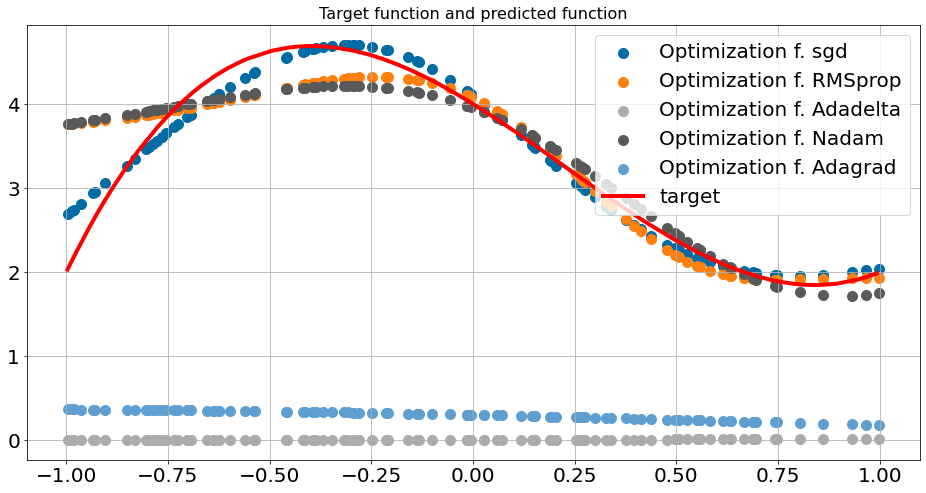

LAYER MODEL


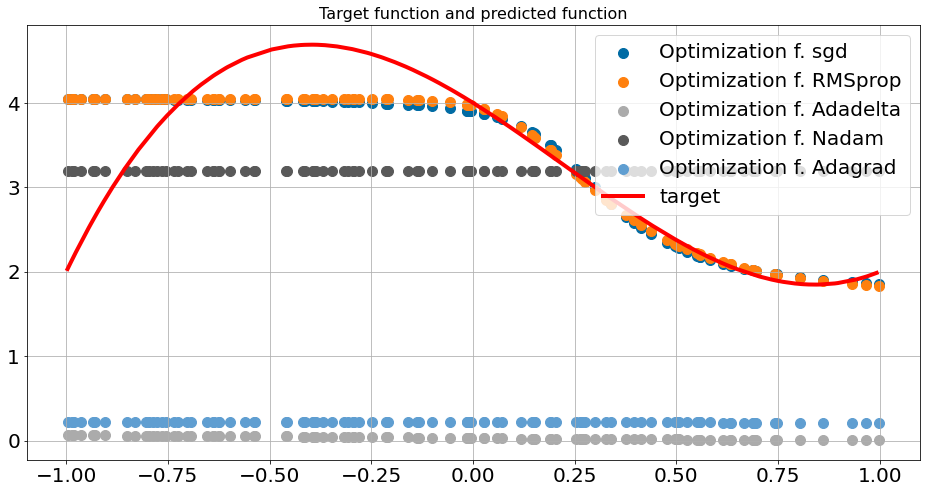

NODE & LAYER MODEL


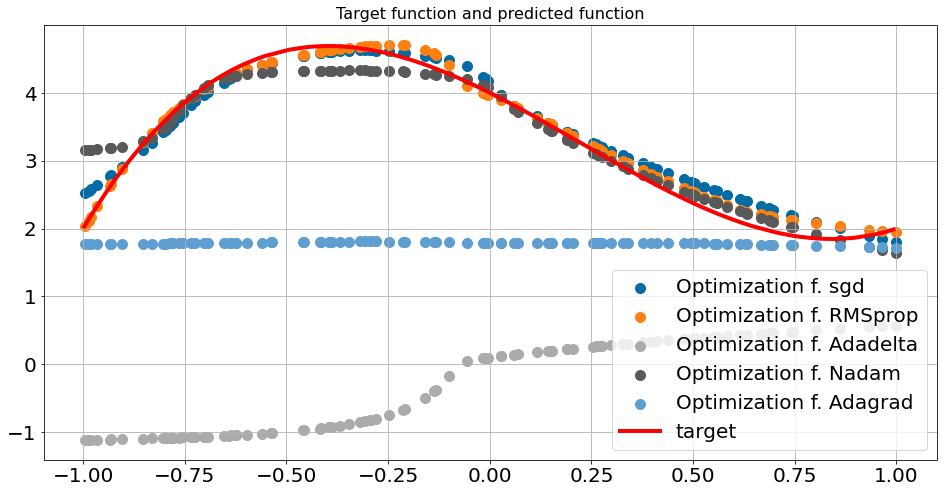

In [24]:
model_count = 0
for y_predict_model in y_predicted:#in the models array
    opt_count = 0
    plt.figure(figsize=(16,8))
    print(f'{mod_names[model_count]}')
    for y_predict_model_optimized in y_predict_model: #the y_predict with optimized parameters
        opt_count = opt_count+1
        plt.title('Target function and predicted function', fontsize=16)
        plt.scatter(x_predicted, y_predict_model_optimized,s = 100, label=f'Optimization f. {optimizer[opt_count-1]}')

    plt.plot(x_valid, y_target,linewidth=4,color='red', label='target')
    plt.legend()
    plt.grid(True)
    plt.show()
    model_count = model_count +1

### Investigate fit performance varying the Loss function

In [25]:
losses = [
    'mean_squared_error',
    'mean_absolute_error',
    'mean_absolute_percentage_error',
    'mean_squared_logarithmic_error',
    'huber_loss'
]


In [26]:
y_predicted= [[],[],[]]
multimodels=[]
multihistory=[]
count=0

for loss in losses:
    print("Loss function ",loss)
    
    multimodels.append(Set_models(n_layer, n_node, bestActivFuncN,bestActivFuncL,bestActivFuncM))
    
    #compiling
    Compile(multimodels[count], [bestOptFuncN,bestOptFuncL,bestOptFuncM],loss,'mse',mod_names)
    
    print("History")
    #starting model
    History(multimodels[count],n_epochs,mod_names)


    y_predicted[0].append(multimodels[count][0].predict(x_predicted))
    y_predicted[1].append(multimodels[count][1].predict(x_predicted))
    y_predicted[2].append(multimodels[count][2].predict(x_predicted))
    count=count+1

Loss function  mean_squared_error
GENERATING MODELS:

Compiling model  Nod_mod
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_238 (Dense)           (None, 1)                 2         
                                                                 
 dense_239 (Dense)           (None, 15)                30        
                                                                 
 dense_240 (Dense)           (None, 1)                 16        
                                                                 
Total params: 48 (192.00 Byte)
Trainable params: 48 (192.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Compiling model  Lay_mod
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_241 (Dense)   

Epoch 1/30
67/67 [==============================] - 2s 6ms/step - loss: 10.1566 - mse: 10.1566 - val_loss: 8.1089 - val_mse: 8.1089
Epoch 2/30
67/67 [==============================] - 0s 3ms/step - loss: 6.3581 - mse: 6.3581 - val_loss: 4.3777 - val_mse: 4.3777
Epoch 3/30
67/67 [==============================] - 0s 3ms/step - loss: 2.8570 - mse: 2.8570 - val_loss: 1.5920 - val_mse: 1.5920
Epoch 4/30
67/67 [==============================] - 0s 3ms/step - loss: 1.0136 - mse: 1.0136 - val_loss: 0.9538 - val_mse: 0.9538
Epoch 5/30
67/67 [==============================] - 0s 3ms/step - loss: 0.6995 - mse: 0.6995 - val_loss: 0.7074 - val_mse: 0.7074
Epoch 6/30
67/67 [==============================] - 0s 3ms/step - loss: 0.4843 - mse: 0.4843 - val_loss: 0.5146 - val_mse: 0.5146
Epoch 7/30
67/67 [==============================] - 0s 3ms/step - loss: 0.3768 - mse: 0.3768 - val_loss: 0.4542 - val_mse: 0.4542
Epoch 8/30
67/67 [==============================] - 0s 3ms/step - loss: 0.3492 - mse: 0.

 dense_259 (Dense)           (None, 1)                 2         
                                                                 
 dense_260 (Dense)           (None, 15)                30        
                                                                 
 dense_261 (Dense)           (None, 1)                 16        
                                                                 
Total params: 48 (192.00 Byte)
Trainable params: 48 (192.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Compiling model  Lay_mod
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_262 (Dense)           (None, 1)                 2         
                                                                 
 dense_263 (Dense)           (None, 1)                 2         
                                                         

Epoch 3/30
67/67 [==============================] - 0s 3ms/step - loss: 2.3803 - mse: 6.7915 - val_loss: 2.1297 - val_mse: 5.8188
Epoch 4/30
67/67 [==============================] - 0s 3ms/step - loss: 2.0067 - mse: 5.1352 - val_loss: 1.7624 - val_mse: 4.3735
Epoch 5/30
67/67 [==============================] - 0s 3ms/step - loss: 1.6548 - mse: 3.8059 - val_loss: 1.4536 - val_mse: 3.2467
Epoch 6/30
67/67 [==============================] - 0s 3ms/step - loss: 1.3683 - mse: 2.7815 - val_loss: 1.2474 - val_mse: 2.3983
Epoch 7/30
67/67 [==============================] - 0s 3ms/step - loss: 1.1688 - mse: 2.0023 - val_loss: 1.1173 - val_mse: 1.7666
Epoch 8/30
67/67 [==============================] - 0s 3ms/step - loss: 1.0343 - mse: 1.4540 - val_loss: 1.0461 - val_mse: 1.3903
Epoch 9/30
67/67 [==============================] - 0s 3ms/step - loss: 0.9554 - mse: 1.1563 - val_loss: 1.0188 - val_mse: 1.2563
Epoch 10/30
67/67 [==============================] - 0s 3ms/step - loss: 0.9273 - mse: 1.0

                                                                 
 dense_282 (Dense)           (None, 1)                 16        
                                                                 
Total params: 48 (192.00 Byte)
Trainable params: 48 (192.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Compiling model  Lay_mod
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_283 (Dense)           (None, 1)                 2         
                                                                 
 dense_284 (Dense)           (None, 1)                 2         
                                                                 
 dense_285 (Dense)           (None, 1)                 2         
                                                                 
 dense_286 (Dense)           (None, 1)                 2 

67/67 [==============================] - 0s 3ms/step - loss: 69.0593 - mse: 6.9090 - val_loss: 64.9289 - val_mse: 6.4180
Epoch 5/30
67/67 [==============================] - 0s 3ms/step - loss: 63.6633 - mse: 6.1587 - val_loss: 59.4574 - val_mse: 5.7328
Epoch 6/30
67/67 [==============================] - 0s 3ms/step - loss: 58.4710 - mse: 5.4901 - val_loss: 54.1410 - val_mse: 5.1125
Epoch 7/30
67/67 [==============================] - 0s 3ms/step - loss: 53.4304 - mse: 4.8823 - val_loss: 48.9436 - val_mse: 4.5504
Epoch 8/30
67/67 [==============================] - 0s 3ms/step - loss: 48.5556 - mse: 4.3276 - val_loss: 43.9973 - val_mse: 4.0418
Epoch 9/30
67/67 [==============================] - 0s 4ms/step - loss: 43.9578 - mse: 3.8295 - val_loss: 40.0983 - val_mse: 3.5834
Epoch 10/30
67/67 [==============================] - 0s 3ms/step - loss: 39.9284 - mse: 3.3769 - val_loss: 36.9215 - val_mse: 3.1759
Epoch 11/30
67/67 [==============================] - 0s 3ms/step - loss: 36.7415 - mse

                                                                 
 dense_303 (Dense)           (None, 1)                 16        
                                                                 
Total params: 48 (192.00 Byte)
Trainable params: 48 (192.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Compiling model  Lay_mod
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_304 (Dense)           (None, 1)                 2         
                                                                 
 dense_305 (Dense)           (None, 1)                 2         
                                                                 
 dense_306 (Dense)           (None, 1)                 2         
                                                                 
 dense_307 (Dense)           (None, 1)                 2 

Epoch 5/30
67/67 [==============================] - 0s 3ms/step - loss: 0.3447 - mse: 4.5254 - val_loss: 0.2541 - val_mse: 3.7369
Epoch 6/30
67/67 [==============================] - 0s 3ms/step - loss: 0.1987 - mse: 3.0907 - val_loss: 0.1463 - val_mse: 2.5051
Epoch 7/30
67/67 [==============================] - 0s 3ms/step - loss: 0.1118 - mse: 1.9865 - val_loss: 0.0907 - val_mse: 1.6587
Epoch 8/30
67/67 [==============================] - 0s 3ms/step - loss: 0.0718 - mse: 1.3094 - val_loss: 0.0753 - val_mse: 1.2887
Epoch 9/30
67/67 [==============================] - 0s 3ms/step - loss: 0.0640 - mse: 1.1046 - val_loss: 0.0754 - val_mse: 1.2636
Epoch 10/30
67/67 [==============================] - 0s 3ms/step - loss: 0.0639 - mse: 1.0969 - val_loss: 0.0757 - val_mse: 1.2592
Epoch 11/30
67/67 [==============================] - 0s 3ms/step - loss: 0.0638 - mse: 1.0948 - val_loss: 0.0755 - val_mse: 1.2610
Epoch 12/30
67/67 [==============================] - 0s 3ms/step - loss: 0.0639 - mse: 1

Total params: 48 (192.00 Byte)
Trainable params: 48 (192.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Compiling model  Lay_mod
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_325 (Dense)           (None, 1)                 2         
                                                                 
 dense_326 (Dense)           (None, 1)                 2         
                                                                 
 dense_327 (Dense)           (None, 1)                 2         
                                                                 
 dense_328 (Dense)           (None, 1)                 2         
                                                                 
 dense_329 (Dense)           (None, 1)                 2         
                                                         

Epoch 7/30
67/67 [==============================] - 0s 3ms/step - loss: 0.5564 - mse: 1.2546 - val_loss: 0.5766 - val_mse: 1.2510
Epoch 8/30
67/67 [==============================] - 0s 3ms/step - loss: 0.4972 - mse: 1.0623 - val_loss: 0.5658 - val_mse: 1.2223
Epoch 9/30
67/67 [==============================] - 0s 3ms/step - loss: 0.4806 - mse: 1.0230 - val_loss: 0.5395 - val_mse: 1.1525
Epoch 10/30
67/67 [==============================] - 0s 3ms/step - loss: 0.4282 - mse: 0.8948 - val_loss: 0.4306 - val_mse: 0.8878
Epoch 11/30
67/67 [==============================] - 0s 3ms/step - loss: 0.2735 - mse: 0.5611 - val_loss: 0.2326 - val_mse: 0.4811
Epoch 12/30
67/67 [==============================] - 0s 3ms/step - loss: 0.1524 - mse: 0.3306 - val_loss: 0.1803 - val_mse: 0.4068
Epoch 13/30
67/67 [==============================] - 0s 3ms/step - loss: 0.1372 - mse: 0.3107 - val_loss: 0.1790 - val_mse: 0.4045
Epoch 14/30
67/67 [==============================] - 0s 3ms/step - loss: 0.1369 - mse:

In [27]:
i=0
j=0

minLossN = 100;
minLossL = 100;
minLossM = 100;
minAccN = 100;
minAccL = 100;
minAccM = 100;
bestLossFuncN = ""
bestLossFuncL = ""
bestLossFuncM = ""
for models in multimodels:
    print("Loss function = ",losses[i])
    for model in models:
        #print(f'{mod_names[j]}')

        score = model.evaluate(x_valid, y_target, batch_size=bs, verbose=0)
        loss = score[0]
        accuracy = score[1]
        print( mod_names[j],"; loss = ",round(loss,4),"; accuracy = ",round(accuracy,4))
        
       
        if j == 0 and minLossN>loss:
            minLossN = loss
            minAccN = accuracy
            bestLossFuncN = losses[i]
        elif j == 1 and minLossL>loss:
            minLossL = loss
            minAccL = accuracy
            bestLossFuncL = losses[i]
        elif j == 2 and minLossM>loss:
            minLossM = loss
            minAccM = accuracy
            bestLossFuncM = losses[i]
        
        j=j+1
    print("__________")
    j=0
    i=i+1
print("The lowest loss value is given by:")
print( "Loss function:",bestLossFuncN,"  Model ", mod_names[0],"; loss = ",round(minLossN,4),"; accuracy = ",round(minAccN,4))
print( "Loss function:",bestLossFuncL,"  Model ",  mod_names[1],"; loss = ",round(minLossL,4),"; accuracy = ",round(minAccL,4))
print( "Loss function:",bestLossFuncM,"  Model ",  mod_names[2],"; loss = ",round(minLossM,4),"; accuracy = ",round(minAccM,4))

Loss function =  mean_squared_error
NODE MODEL ; loss =  0.0803 ; accuracy =  0.0803
LAYER MODEL ; loss =  0.3481 ; accuracy =  0.3481
NODE & LAYER MODEL ; loss =  0.0059 ; accuracy =  0.0059
__________
Loss function =  mean_absolute_error
NODE MODEL ; loss =  0.2617 ; accuracy =  0.2609
LAYER MODEL ; loss =  1.0107 ; accuracy =  1.2122
NODE & LAYER MODEL ; loss =  0.1499 ; accuracy =  0.033
__________
Loss function =  mean_absolute_percentage_error
NODE MODEL ; loss =  10.314 ; accuracy =  0.1507
LAYER MODEL ; loss =  32.097 ; accuracy =  1.5148
NODE & LAYER MODEL ; loss =  32.0673 ; accuracy =  1.5224
__________
Loss function =  mean_squared_logarithmic_error
NODE MODEL ; loss =  0.052 ; accuracy =  0.9191
LAYER MODEL ; loss =  0.0708 ; accuracy =  1.203
NODE & LAYER MODEL ; loss =  0.0174 ; accuracy =  0.3366
__________
Loss function =  huber_loss
NODE MODEL ; loss =  0.3528 ; accuracy =  0.8485
LAYER MODEL ; loss =  0.1527 ; accuracy =  0.3518
NODE & LAYER MODEL ; loss =  0.0041 ; 

NODE MODEL


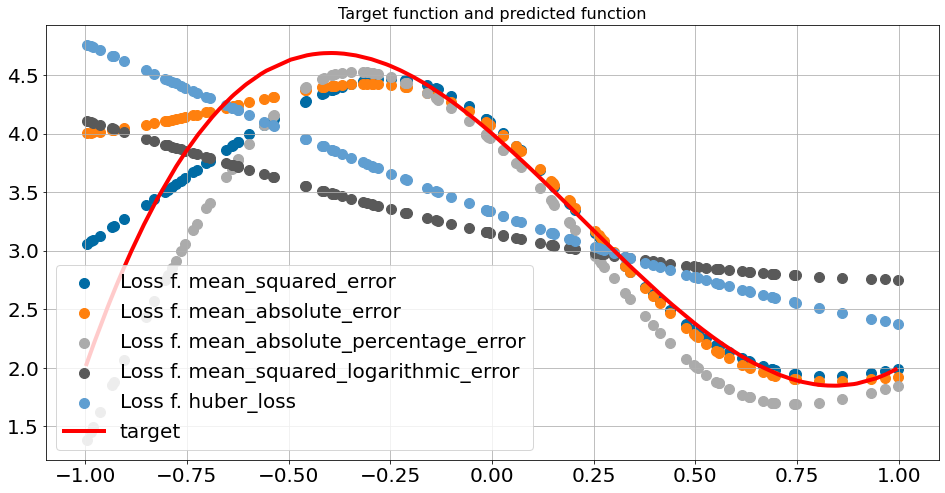

LAYER MODEL


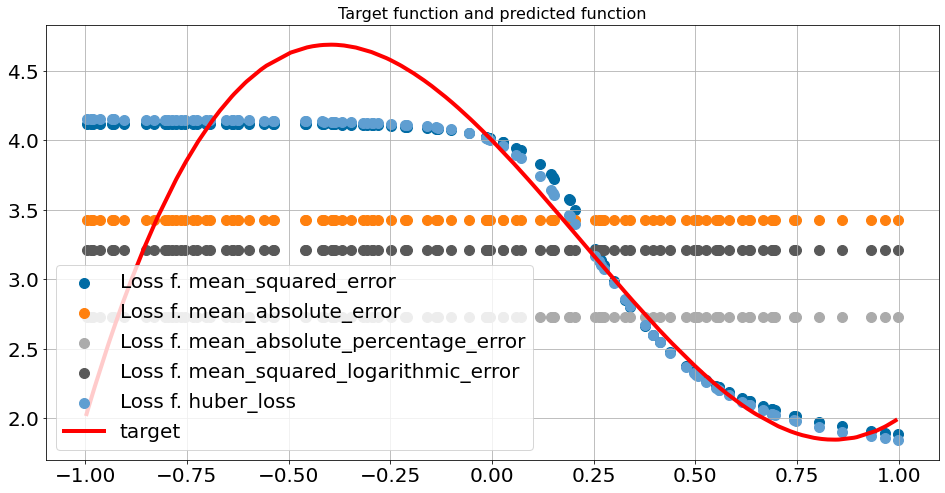

NODE & LAYER MODEL


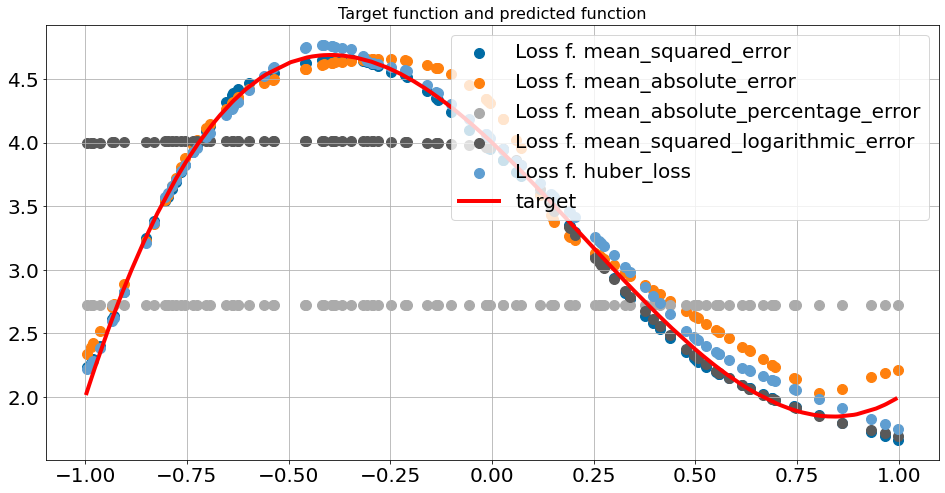

In [28]:
model_count = 0
for y_predict_model in y_predicted:#in the models array
    opt_count = 0
    plt.figure(figsize=(16,8))
    print(f'{mod_names[model_count]}')
    for y_predict_model_optimized in y_predict_model: #the y_predict with optimized parameters
        opt_count = opt_count+1
        plt.title('Target function and predicted function', fontsize=16)
        plt.scatter(x_predicted, y_predict_model_optimized,s = 100, label=f'Loss f. {losses[opt_count-1]}')

    plt.plot(x_valid, y_target,linewidth=4,color='red', label='target')
    plt.legend()
    plt.grid(True)
    plt.show()
    model_count = model_count +1

I increase the number of nodes and the size of the training dataset and then evaluate the final fit.

In [29]:
n_train = 50000
n_epochs = 30
n_layer = 10
n_node = 30
bs = 150 #banchsize
y_predicted = []
x_predicted = np.random.uniform(-3, 3, 100)
#generate input data
x_train, x_valid, y_target ,y_train, y_valid = generate_input(n_train)

#setting model
models = Set_models(n_layer, n_node, bestActivFuncN,bestActivFuncL,bestActivFuncM)

#compiling
Compile(models, [bestOptFuncN,bestOptFuncL,bestOptFuncM],'mse','mse',mod_names)#SGD o Adam

#starting model
histo = History(models,n_epochs,mod_names)

y_predicted.append(models[0].predict(x_predicted))
y_predicted.append(models[1].predict(x_predicted))
y_predicted.append(models[2].predict(x_predicted))

GENERATING MODELS:

Compiling model  Nod_mod
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_343 (Dense)           (None, 1)                 2         
                                                                 
 dense_344 (Dense)           (None, 30)                60        
                                                                 
 dense_345 (Dense)           (None, 1)                 31        
                                                                 
Total params: 93 (372.00 Byte)
Trainable params: 93 (372.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Compiling model  Lay_mod
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_346 (Dense)           (None, 1)                 

Epoch 1/30
334/334 [==============================] - 2s 3ms/step - loss: 10.0938 - mse: 10.0938 - val_loss: 7.7339 - val_mse: 7.7339
Epoch 2/30
334/334 [==============================] - 1s 2ms/step - loss: 4.5496 - mse: 4.5496 - val_loss: 2.2138 - val_mse: 2.2138
Epoch 3/30
334/334 [==============================] - 1s 2ms/step - loss: 1.2628 - mse: 1.2628 - val_loss: 1.0675 - val_mse: 1.0675
Epoch 4/30
334/334 [==============================] - 1s 2ms/step - loss: 1.0756 - mse: 1.0756 - val_loss: 1.0663 - val_mse: 1.0663
Epoch 5/30
334/334 [==============================] - 1s 2ms/step - loss: 0.8535 - mse: 0.8535 - val_loss: 0.2308 - val_mse: 0.2308
Epoch 6/30
334/334 [==============================] - 1s 2ms/step - loss: 0.2895 - mse: 0.2895 - val_loss: 0.2181 - val_mse: 0.2181
Epoch 7/30
334/334 [==============================] - 1s 2ms/step - loss: 0.2884 - mse: 0.2884 - val_loss: 0.2160 - val_mse: 0.2160
Epoch 8/30
334/334 [==============================] - 1s 2ms/step - loss: 

NODE MODEL


------------------------------------------------------

1/1 [==============================] - 0s 31ms/step - loss: 1.3549 - mse: 1.3549

Evaluation of the model by comparison with the exact curve:
Test loss: 1.3548752069473267
Test accuracy: 1.3548752069473267


------------------------------------------------------


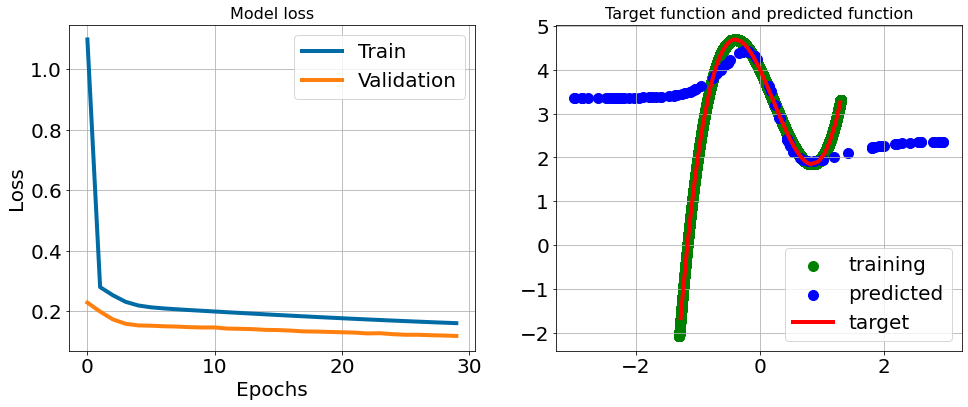

LAYER MODEL


------------------------------------------------------

1/1 [==============================] - 0s 28ms/step - loss: 1.9531 - mse: 1.9531

Evaluation of the model by comparison with the exact curve:
Test loss: 1.9531042575836182
Test accuracy: 1.9531042575836182


------------------------------------------------------


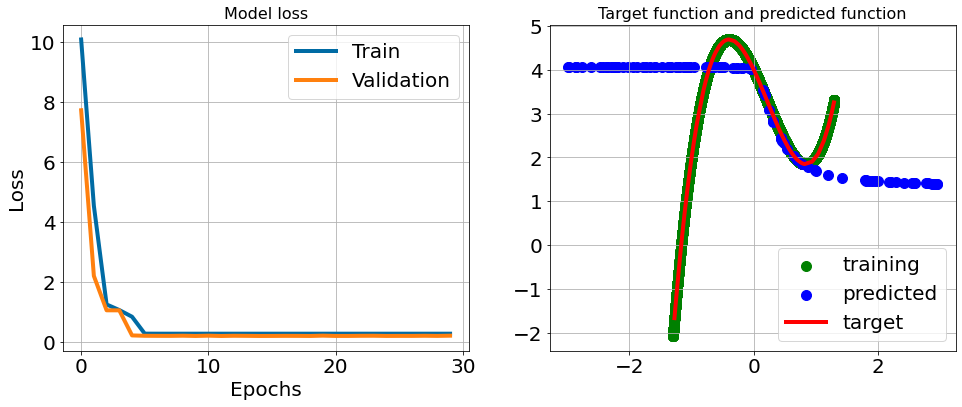

NODE & LAYER MODEL


------------------------------------------------------

1/1 [==============================] - 0s 29ms/step - loss: 0.3316 - mse: 0.3316

Evaluation of the model by comparison with the exact curve:
Test loss: 0.3316131830215454
Test accuracy: 0.3316131830215454


------------------------------------------------------


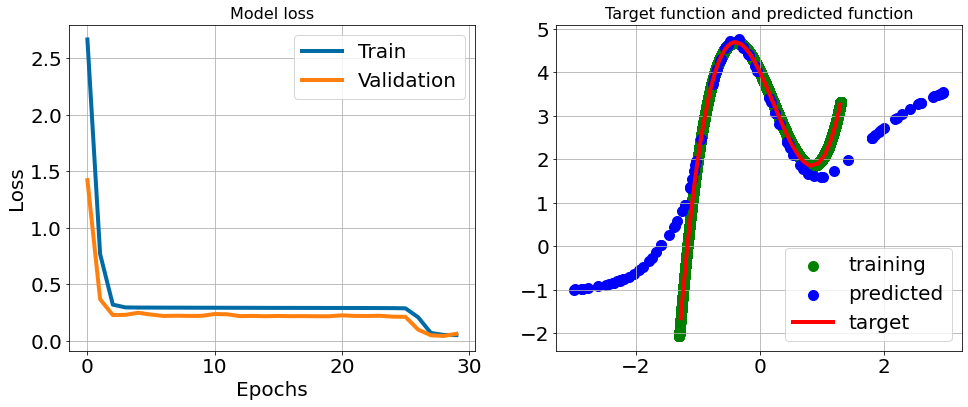

In [30]:
# generate training inputs
n_valid = 100
np.random.seed(0)
x_train = np.random.uniform(-1.3, 1.3, n_train)
x_valid = np.random.uniform(-1.3, 1.3, n_valid)
x_valid.sort()

y_target = polynomial(x_valid) # ideal (target) linear function
y_valid = np.random.normal(polynomial(x_valid),0)

y_train = np.random.normal(polynomial(x_train),0) # actual measures from which we want to guess regression parameters


for i in range(len(models)):
    print(f'{mod_names[i]}')
    print_performance(models[i], y_target, x_valid, y_valid,150)

    # look into training history
    # Plot training & validation loss values
    plt. subplots(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(histo[i].history['loss'],linewidth=4)
    plt.plot(histo[i].history['val_loss'],linewidth=4)
    plt.title('Model loss', fontsize=16)
    plt.grid()
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='best')

    # Plot target and fit
    plt.subplot(1,2,2)
    plt.title('Target function and predicted function', fontsize=16)

   # Fitted function
    #plt.plot(x_predicted, y_predicted,'ro', label='predicted')

    plt.scatter(x_train, y_train,s = 100,color = 'green', label='training')
    plt.scatter(x_predicted, y_predicted[i],s = 100,color = 'blue', label='predicted')
    # Target function
    plt.plot(x_valid, y_target,linewidth=4,color='red', label='target')
    plt.legend()
    plt.grid(True)
    plt.show()

### Final observation
The best fit is achieved by the MIX model. This suggests that the geometry in which the layers and their respective nodes are constructed plays a significant role in the final outcome.

The fit is consistent with the validation data within the training region; however, it exhibits poor performance outside the training region. From this, we can conclude that a neural network may not be suitable for this type of analysis.

For the Fit the best way to proceed is to use:
- loss function **mean square error** (MSE), 
- optimization method **Stochastic Gradient Descent** (sgd)
- activation function **Exponential Linear Unit** (elu) o (selu)


### Exercise 11.3
  
Try to extend the model to fit a simple trigonometric 2D function such as $f(x,y) = \sin(x^2+y^2)$ in the range $x \in [-3/2,3/2]$ and $y \in [-3/2,3/2]$.

In [45]:
np.random.seed(0)

# generate training inputs
sigma = 0.2
n_train = 20000
n_epochs = 20
n_node = 5
n_valid = int(n_train/10)

x_train = np.random.uniform(-3/2, 3/2, n_train)
y_train = np.random.uniform(-3/2, 3/2, n_train)
x_valid = np.random.uniform(-3/2, 3/2, n_valid)
y_valid = np.random.uniform(-3/2, 3/2, n_valid)
x_valid.sort()
y_valid.sort()

z_target = np.sin(x_train*x_train+y_train*y_train)

z_train = np.random.normal(np.sin(x_train*x_train+y_train*y_train), sigma)
z_valid = np.random.normal(np.sin(x_valid*x_valid+y_valid*y_valid), sigma)



# compose the NN model
model = tf.keras.Sequential()
model.add(Dense(1, input_shape=(2,),activation='selu'))
for i in range(3): model.add(Dense(4+i, input_shape=(2,),activation='selu'))
for i in range(3): model.add(Dense(5-i, input_shape=(2,),activation='selu'))
model.add(Dense(1, input_shape=(2,),activation='selu'))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='Nadam', loss='mse', metrics=['mse'])

# get a summary of our composed model
model.summary()

# save the weights that we will use later
model.save_weights('./Weights/ex11.3.h5')

    

history = model.fit(x=np.array([x_train,y_train]).T, y= z_train, 
        batch_size=32, epochs=n_epochs,
        shuffle=True, # a good idea is to shuffle input before at each epoch
        validation_data=(np.array([x_valid, y_valid]).T ,z_valid),
        verbose = 1)

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_372 (Dense)           (None, 1)                 3         
                                                                 
 dense_373 (Dense)           (None, 4)                 8         
                                                                 
 dense_374 (Dense)           (None, 5)                 25        
                                                                 
 dense_375 (Dense)           (None, 6)                 36        
                                                                 
 dense_376 (Dense)           (None, 5)                 35        
                                                                 
 dense_377 (Dense)           (None, 4)                 24        
                                                                 
 dense_378 (Dense)           (None, 3)               

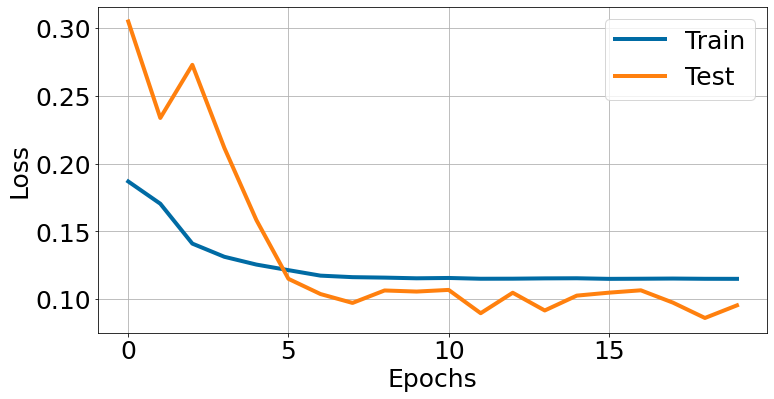

16/16 [==============================] - 0s 983us/step


Text(0.5, 0.92, 'Prediction')

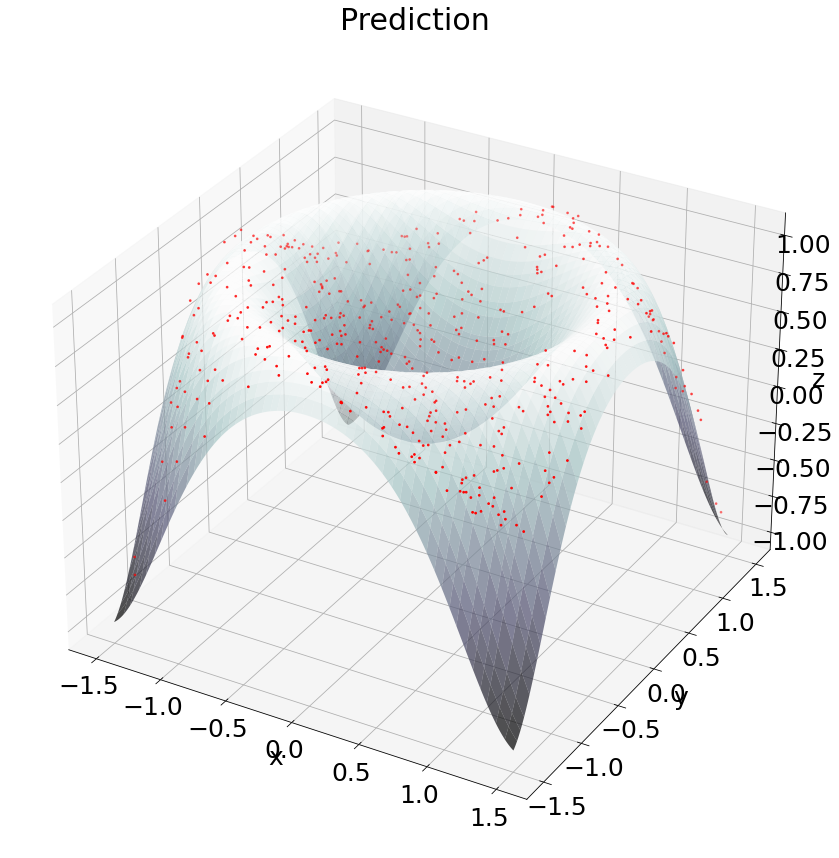

In [46]:
plt.figure(figsize = (12,6))
plt.rcParams.update({'font.size': 25})
plt.plot(history.history['loss'],linewidth = 4)
plt.plot(history.history['val_loss'],linewidth = 4)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='best')
plt.grid(True)

plt.show()

plt.figure(figsize =(28,15))
x_predicted = np.random.uniform(-1.5, 1.5, 500)
y_predicted = np.random.uniform(-1.5,1.5,500)
z_predicted = model.predict(np.array([x_predicted,y_predicted]).T)

X,Y = np.meshgrid(x_valid,y_valid)
np.meshgrid(x_predicted,y_predicted,z_predicted)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, np.sin(X*X+Y*Y), cmap = 'bone', alpha = 0.7,label =" Valid dataset")

ax.scatter(x_predicted, y_predicted, z_predicted, color='r', s=3)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("Prediction")